In [2]:
import gymnasium as gym
import numpy as np

class missile_interception_3d(gym.Env):
    def __init__(self):
        # 1. Define Action Space (The Joystick: Left/Right, Up/Down)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2, ), dtype=np.float32)
        
        # 2. Define Observation Space (16D ego-frame, no actuator state)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(16,), dtype=np.float32)

        self.np_random = np.random.RandomState()
        
        # 3. Time Settings
        self.dt_act = 0.1             
        self.n_substeps = 10          
        self.dt_sim = self.dt_act / self.n_substeps 
        self.t_max = 650.0 # REVISAR IF THIS IS ENOF         

        # 4. Physical Limits
        self.a_max = 350.0   # Max G-force (m/s^2) ~35G
        self.g = 9.81        
        self.collision_radius = 150.0  
        self.max_distance = 4_000_000.0 

        # LET'S REMOVE THE "HARD CASES"

        self.p_easy = 1.0                   
        self.range_min = 70_000.0           
        self.range_easy_max = 200_000.0     
        self.range_hard_max = 1_000_000.0   

        self.targetbox_x_min = -15000
        self.targetbox_x_max = 15000
        self.targetbox_y_min = -15000
        self.targetbox_y_max = 15000

        # --- Closest-approach shaping ---
        self.gamma_shape = 0.9999      # set = PPO gamma when training
        self.w_ca = 10.0
        self.dstar_scale = 50_000.0   # meters; tune so r_ca ~ 0.05-0.15 under ProNav

    def generate_enemy_missile(self):
        if self.np_random.rand() < self.p_easy:
            self.range_max_used = self.range_easy_max
        else:
            self.range_max_used = self.range_hard_max

        range_min = self.range_min
        self.attack_target_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.attack_target_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)
        self.enemy_launch_angle = self.np_random.uniform(0, 2 * np.pi)
        self.enemy_theta = self.np_random.uniform(0.523599, 1.0472) 

        self.range_max_used = max(self.range_max_used, range_min + 1.0)
        lower_limit = np.sqrt((range_min * self.g) / np.sin(2 * self.enemy_theta))
        upper_limit = np.sqrt((self.range_max_used * self.g) / np.sin(2 * self.enemy_theta))
        self.enemy_initial_velocity = self.np_random.uniform(lower_limit, upper_limit)

        ground_range = (
            self.enemy_initial_velocity * np.cos(self.enemy_theta)
            * (2 * self.enemy_initial_velocity * np.sin(self.enemy_theta) / self.g)
        )

        self.enemy_launch_x = self.attack_target_x + ground_range * np.cos(self.enemy_launch_angle)
        self.enemy_launch_y = self.attack_target_y + ground_range * np.sin(self.enemy_launch_angle)
        self.enemy_z = 0
        self.enemy_x = self.enemy_launch_x
        self.enemy_y = self.enemy_launch_y
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_azimuth = (self.enemy_launch_angle + np.pi) % (2 * np.pi)

    def generate_defense_missile(self):
        self.defense_launch_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.defense_launch_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)

        dx = self.enemy_launch_x - self.defense_launch_x
        dy = self.enemy_launch_y - self.defense_launch_y
        az_nominal = np.arctan2(dy, dx)

        # --- Misalignment (domain randomization of initial heading) ---
        # Mixture: most episodes small error, some episodes large az error
        p_misaligned = 0.35  # 35% "hard" starts
        if self.np_random.rand() < p_misaligned:
            # Hard: big azimuth error → strong RIGHT required
            az_noise = self.np_random.uniform(-np.deg2rad(60.0), np.deg2rad(60.0))
        else:
            # Easy: small azimuth error → gentle correction
            az_noise = self.np_random.uniform(-np.deg2rad(10.0), np.deg2rad(10.0))

        self.defense_azimuth = az_nominal + az_noise

        # Elevation noise: avoid always same vertical plane
        theta_nominal = 0.785398  # ~45 deg
        theta_noise_deg = 10.0
        theta_noise = self.np_random.uniform(
            -np.deg2rad(theta_noise_deg),
            +np.deg2rad(theta_noise_deg),
        )
        self.defense_theta = float(np.clip(theta_nominal + theta_noise,
                                           np.deg2rad(10.0),
                                           np.deg2rad(80.0)))
        # ---------------------------------------------------------------

        base_velocity = 3000.0
        if hasattr(self, 'range_max_used'):
            velocity_scale = min(self.range_max_used / self.range_easy_max, 1.5)
            self.defense_initial_velocity = base_velocity * velocity_scale
        else:
            self.defense_initial_velocity = base_velocity

        self.defense_x = self.defense_launch_x
        self.defense_y = self.defense_launch_y
        self.defense_z = 0.0
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)
    
    def _smoothstep(self, x: float) -> float:
        """Smooth ramp 0->1 with zero slope at ends, clamps outside [0,1]"""
        x = float(np.clip(x, 0.0, 1.0))
        return x * x * (3.0 - 2.0 * x)
    
    def calculate_pronav(self):
        eps = 1e-9

        # Relative geometry (use float64 for stability)
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        v = self.defense_vel.astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        V = float(np.linalg.norm(v)) + eps

        rhat = r / R
        vhat = v / V

        # Heading error alpha = angle between velocity direction and LOS direction
        cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
        alpha = float(np.arccos(cosang))  # radians

        # LOS angular rate omega (world frame)
        omega = np.cross(r, vrel) / (float(np.dot(r, r)) + eps)
        omega_mag = float(np.linalg.norm(omega))

        # Closing speed (positive => closing)
        vc = -float(np.dot(r, vrel)) / R

        # --- PN term ---
        N = 3.0
        a_pn = N * vc * np.cross(omega, rhat)  # lateral accel in world frame

        # --- Acquisition term (turn-to-LOS) ---
        # Perpendicular component of LOS relative to forward direction
        rhat_perp = rhat - float(np.dot(rhat, vhat)) * vhat
        nperp = float(np.linalg.norm(rhat_perp))

        if nperp < 1e-8:
            a_acq = np.zeros(3, dtype=np.float64)
        else:
            rhat_perp /= nperp  # unit sideways "turn toward LOS" direction

            # Curvature-based magnitude: ~k * V^2 / R, saturate later via a_max
            k_acq = 5.0  # try 3.0–8.0
            a_acq = k_acq * (V * V / R) * rhat_perp

        # --- Blend weight w: 0 => pure PN, 1 => pure acquisition ---

        # Alpha-based weight (dominant)
        alpha_on   = np.deg2rad(20.0)   # start blending earlier
        alpha_full = np.deg2rad(55.0)

        x_alpha = (alpha - alpha_on) / (alpha_full - alpha_on + eps)
        w_alpha = self._smoothstep(x_alpha)

        # Omega-based modifier (only boosts acquisition when PN is sleepy)
        omega_full = 0.00
        omega_on   = 0.05   # <-- key: less brittle than 0.02

        x_omega = (omega_on - omega_mag) / (omega_on - omega_full + eps)
        w_omega = self._smoothstep(x_omega)

        # Robust combine: alpha dominates; omega can't fully shut it off
        w = w_alpha * (0.25 + 0.75 * w_omega)

        # Optional: if not closing, force strong acquisition
        if vc <= 0.0:
            w = max(w, 0.9)

        a_ideal = (1.0 - w) * a_pn + w * a_acq

        # Project into your lateral control basis (right/up) and normalize by a_max
        # Note: Environment now handles gravity compensation internally,
        # so ProNav outputs desired NET lateral accel (same semantics as PPO)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)
        a_right = float(np.dot(a_ideal, right))
        a_up    = float(np.dot(a_ideal, up))

        action = np.array([a_right / self.a_max, a_up / self.a_max], dtype=np.float32)
        return np.clip(action, -1.0, 1.0)
    
    def _segment_sphere_intersect(self, r0, r1, r_hit):
        dr = r1 - r0
        dr_norm_sq = float(np.dot(dr, dr))
        if dr_norm_sq < 1e-12:
            return float(np.dot(r0, r0)) <= r_hit * r_hit
        s_star = -float(np.dot(r0, dr)) / dr_norm_sq
        s_star = max(0.0, min(1.0, s_star))
        r_closest = r0 + s_star * dr
        return float(np.dot(r_closest, r_closest)) <= r_hit * r_hit
    
    def _phi_closest_approach(self):
        """
        Potential based on closest-approach miss distance under
        constant relative velocity assumption.
        Returns:
            phi, d_star, t_star
        """
        eps = 1e-9

        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        vrel_norm_sq = float(np.dot(vrel, vrel)) + eps

        # t* = argmin ||r + vrel t|| for t >= 0
        t_star = -float(np.dot(r, vrel)) / vrel_norm_sq
        t_star = max(0.0, t_star)

        m_star = r + vrel * t_star
        d_star = float(np.linalg.norm(m_star))

        phi = -d_star / (self.dstar_scale + eps)
        return float(phi), d_star, float(t_star)
    
    def _get_obs(self):
        eps = 1e-9

        # World-frame relative state
        r_world = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel_world = (self.enemy_vel - self.defense_vel).astype(np.float64)

        # Local basis from defense velocity (world frame unit vectors)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)

        # ===============================
        # 1) Ego-frame (body-frame) r and vrel
        # ===============================
        r_body = np.array([
            float(np.dot(r_world, forward)),
            float(np.dot(r_world, right)),
            float(np.dot(r_world, up)),
        ], dtype=np.float64)

        vrel_body = np.array([
            float(np.dot(vrel_world, forward)),
            float(np.dot(vrel_world, right)),
            float(np.dot(vrel_world, up)),
        ], dtype=np.float64)

        # Normalize r_body / vrel_body (easy range only)
        pos_scale = float(self.range_easy_max)
        vel_scale = 4000.0

        r_body_n = (r_body / (pos_scale + eps)).astype(np.float32)
        vrel_body_n = (vrel_body / (vel_scale + eps)).astype(np.float32)

        # ===============================
        # 2) Scalar helpers
        # ===============================
        dist = float(np.linalg.norm(r_world)) + 1e-6
        v_close = -float(np.dot(r_world, vrel_world)) / dist  # positive when closing

        dist_n = np.float32(np.clip(dist / 1_000_000.0, 0.0, 4.0))
        vclose_n = np.float32(np.clip(v_close / 3000.0, -2.0, 2.0))
        dist_vclose_feat = np.array([dist_n, vclose_n], dtype=np.float32)

        # Defense own vertical state (keep for ground constraint)
        def_z_n = np.float32(np.clip(self.defense_pos[2] / 100_000.0, -1.0, 2.0))
        def_vz_n = np.float32(np.clip(self.defense_vel[2] / 3000.0, -2.0, 2.0))
        def_state_feat = np.array([def_z_n, def_vz_n], dtype=np.float32)

        # ===============================
        # 4) Keep your geometry features (consistent with ego-frame)
        # ===============================
        dist_body = float(np.linalg.norm(r_body)) + 1e-6

        # LOS lateral projections in body frame
        los_right = float(r_body[1] / dist_body)
        los_up    = float(r_body[2] / dist_body)

        # LOS rate omega in body frame: omega = (r x vrel)/||r||^2
        dist2_body = float(np.dot(r_body, r_body)) + eps
        omega_body = np.cross(r_body, vrel_body) / dist2_body

        omega_right = float(omega_body[1])
        omega_up    = float(omega_body[2])

        omega_scale = 2.0
        omega_right_n = float(np.clip(omega_right / omega_scale, -2.0, 2.0))
        omega_up_n    = float(np.clip(omega_up / omega_scale, -2.0, 2.0))

        geom_feat = np.array([los_right, los_up, omega_right_n, omega_up_n], dtype=np.float32)

        # ===============================
        # 5) NEW: kinematics garnish
        # ===============================
        V_def = float(np.linalg.norm(self.defense_vel))
        V_def_n = np.float32(np.clip(V_def / 3000.0, 0.0, 3.0))  # scale: 3000 m/s baseline
        forward_z = np.float32(float(forward[2]))               # dot(forward, world_up) since world_up=[0,0,1]

        kin_feat = np.array([V_def_n, forward_z], dtype=np.float32)

        # Final obs (16D, no actuator state)
        obs = np.concatenate(
            [r_body_n, vrel_body_n, dist_vclose_feat, def_state_feat, geom_feat, kin_feat],
            axis=0
        ).astype(np.float32)

        return obs

    def _compute_lateral_basis(self, velocity):
        """
        Horizon-stable basis:
          forward = along velocity
          right   = world_up x forward  (horizontal right)
          up      = forward x right     (completes orthonormal frame)
        This keeps 'up' as close to world-up as possible and avoids weird twisting.
        """
        speed = float(np.linalg.norm(velocity))
        if speed < 1.0:
            forward = np.array([1.0, 0.0, 0.0], dtype=np.float32)
        else:
            forward = (velocity / speed).astype(np.float32)

        world_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)

        # right = world_up x forward
        right_raw = np.cross(world_up, forward)
        rnorm = float(np.linalg.norm(right_raw))

        # If forward is near world_up, right_raw ~ 0. Pick a consistent fallback.
        if rnorm < 1e-6:
            # Choose a fixed "north" axis in world XY and build right from that
            # This prevents random spinning when vertical.
            north = np.array([1.0, 0.0, 0.0], dtype=np.float32)
            right_raw = np.cross(north, forward)
            rnorm = float(np.linalg.norm(right_raw))
            if rnorm < 1e-6:
                north = np.array([0.0, 1.0, 0.0], dtype=np.float32)
                right_raw = np.cross(north, forward)
                rnorm = float(np.linalg.norm(right_raw))

        right = (right_raw / (rnorm + 1e-9)).astype(np.float32)

        # up = forward x right (not right x forward)
        up_raw = np.cross(forward, right)
        up = (up_raw / (float(np.linalg.norm(up_raw)) + 1e-9)).astype(np.float32)

        return forward, right, up

    def step(self, action, skip_projection=False):
        if getattr(self, "done", False):
            return self._get_obs(), 0.0, True, False, {"event": "called_step_after_done", "dist": float(np.linalg.norm(self.enemy_pos - self.defense_pos)), "proj_fired": 0.0, "mag_in": float(np.nan), "mag_exec": float(np.nan)}
        
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        action_in = action.copy()
        mag_in = float(np.linalg.norm(action_in))
        proj_fired = 0.0
        if not skip_projection and mag_in > 1.0:
            action = action_in / mag_in
            proj_fired = 1.0
        mag_exec = float(np.linalg.norm(action))
        
        # Update episode trackers
        self.ep_max_action_mag = max(self.ep_max_action_mag, mag_exec)

        dist_before = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        
        # --- Shaping: closest-approach potential BEFORE transition ---
        phi_before, dstar_before, tstar_before = self._phi_closest_approach()
        terminated = False
        truncated = False
        event = "running"
        
        for _ in range(self.n_substeps):
            dt = self.dt_sim
            enemy_pos_old = self.enemy_pos.copy()
            defense_pos_old = self.defense_pos.copy()
            
            forward, right, up = self._compute_lateral_basis(self.defense_vel)
            g_vec = np.array([0.0, 0.0, -self.g], dtype=np.float32)
            # Direct commanded lateral accel (no lag/jerk)
            a_lat = (action[0] * self.a_max) * right + (action[1] * self.a_max) * up
            self.defense_vel += (a_lat + g_vec) * dt
            self.defense_pos += self.defense_vel * dt
            self.defense_x, self.defense_y, self.defense_z = self.defense_pos
            
            # Enemy missile: pure ballistic (gravity only)
            self.enemy_vel += g_vec * dt
            self.enemy_pos += self.enemy_vel * dt
            self.enemy_x, self.enemy_y, self.enemy_z = self.enemy_pos
            self.t += dt
            
            r0 = enemy_pos_old - defense_pos_old
            r1 = self.enemy_pos - self.defense_pos
            if self._segment_sphere_intersect(r0, r1, self.collision_radius):
                self.success = True
                terminated = True
                self.done = True
                event = "hit"
                self.time_to_hit = float(self.t)
                self.terminal_event = "hit"
                break
            
            dist = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
            if dist > self.max_distance:
                truncated = True
                self.done = True
                event = "diverged"
                self.terminal_event = "diverged"
                break
            if self.defense_pos[2] < 0:
                terminated = True
                self.done = True
                event = "defense_ground"
                self.terminal_event = "defense_ground"
                break
            if self.enemy_pos[2] < 0:
                terminated = True
                self.done = True
                event = "enemy_ground"
                self.terminal_event = "enemy_ground"
                break
            if self.t >= self.t_max:
                truncated = True
                self.done = True
                event = "timeout"
                self.terminal_event = "timeout"
                break

        obs = self._get_obs()
        dist_after = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        self.min_dist = min(getattr(self, "min_dist", float("inf")), dist_after)
        self.ep_min_dist = min(self.ep_min_dist, float(dist_after))
        
        # Reward: ZEM shaping + closing only
        v_scale = 1500.0
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)
        d = float(np.linalg.norm(r)) + 1e-9
        rhat = r / d
        r_close = float(np.tanh(-float(np.dot(rhat, vrel)) / v_scale))
        phi_after, _, _ = self._phi_closest_approach()  # always (no free jackpot on termination)
        r_ca = self.w_ca * (self.gamma_shape * phi_after - phi_before)
        reward = float(0.5 * r_ca + 0.5 * 0.1 * r_close)
        final_event = event
        if terminated or truncated:
            self.terminal_event = event
        info = {"event": final_event, "t": float(self.t), "dist": float(dist_after), "r_ca": float(r_ca), "r_close": float(r_close), "proj_fired": float(proj_fired), "mag_in": float(mag_in), "mag_exec": float(mag_exec)}
        if terminated or truncated:
            info["min_dist"] = float(self.ep_min_dist)
            info["max_action_mag"] = float(self.ep_max_action_mag)
            info["time_to_hit"] = float(self.time_to_hit) if self.time_to_hit is not None else np.nan
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None: self.np_random = np.random.RandomState(seed)
        self.done = False
        self.success = False
        self.t = 0.0
        self.generate_enemy_missile()
        self.generate_defense_missile()
        
        self.defense_vel = np.array([
            self.defense_initial_velocity * np.cos(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_theta)
        ], dtype=np.float32)
        
        self.enemy_vel = np.array([
            self.enemy_initial_velocity * np.cos(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_theta)
        ], dtype=np.float32)
        
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.min_dist = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        self.ep_min_dist = float("inf")
        self.ep_max_action_mag = 0.0
        self.time_to_hit = None
        self.terminal_event = "running"
        
        return self._get_obs(), {}


# Same physics, no unit-ball projection (for A/B experiment)
class missile_interception_3d_no_proj(missile_interception_3d):
    def step(self, action):
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        return super().step(action, skip_projection=True)


# ==========================================
# EVALUATION FUNCTION (separate from training reward)
# ==========================================
def evaluate_policy(env, policy_fn, n_episodes=100, seed0=0):
    """
    Evaluate a policy and return episode-level metrics.
    This is separate from training reward - these metrics are what you actually care about.
    
    Args:
        env: missile_interception_3d environment instance
        policy_fn: Function that takes obs and returns action
        n_episodes: Number of episodes to evaluate
        seed0: Starting seed (episodes use seed0, seed0+1, ..., seed0+n_episodes-1)
    
    Returns:
        summary: Dict with aggregated metrics (hit_rate, min_dist stats, etc.)
        metrics: Dict with raw episode data
    """
    metrics = {
        "hits": 0,
        "ground_defense": 0,
        "ground_enemy": 0,
        "diverged": 0,
        "timeout": 0,
        "min_dist_list": [],
        "time_to_hit_list": [],
        "max_g_list": [],
    }

    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + i)
        done = False

        while not done:
            action = policy_fn(obs)  # your PPO policy OR env.calculate_pronav() baseline
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        event = info["event"]
        metrics["min_dist_list"].append(env.ep_min_dist)
        metrics["max_g_list"].append(env.ep_max_action_mag)

        if event == "hit":
            metrics["hits"] += 1
            if env.time_to_hit is not None:
                metrics["time_to_hit_list"].append(env.time_to_hit)
        elif event == "defense_ground":
            metrics["ground_defense"] += 1
        elif event == "enemy_ground":
            metrics["ground_enemy"] += 1
        elif event == "diverged":
            metrics["diverged"] += 1
        elif event == "timeout":
            metrics["timeout"] += 1

    hit_rate = metrics["hits"] / n_episodes

    summary = {
        "hit_rate": hit_rate,
        "min_dist_mean": float(np.mean(metrics["min_dist_list"])),
        "min_dist_p50": float(np.median(metrics["min_dist_list"])),
        "min_dist_p10": float(np.percentile(metrics["min_dist_list"], 10)),
        "time_to_hit_mean": float(np.mean(metrics["time_to_hit_list"])) if metrics["time_to_hit_list"] else None,
        "max_g_mean": float(np.mean(metrics["max_g_list"])),
        "violations": {
            "defense_ground": metrics["ground_defense"],
            "enemy_ground": metrics["ground_enemy"],
            "diverged": metrics["diverged"],
            "timeout": metrics["timeout"],
        }
    }
    return summary, metrics




# def run_baseline():
#     env = missile_interception_3d()
#     outcomes = []
#     min_distances = []
#     action_loads = [] # Track if we are saturating (maxing out fins)

#     N_EPISODES = 50
#     print(f"Running {N_EPISODES} episodes of Augmented ProNav...")

#     for i in range(N_EPISODES):
#         obs, _ = env.reset(seed=i)
#         done = False
#         ep_actions = []

#         while not done:
#             # 1. Ask ProNav for the move
#             action = env.calculate_pronav()
            
#             # 2. Track how hard it's pushing (0.0 to 1.0)
#             mag = np.linalg.norm(action)
#             ep_actions.append(mag)

#             obs, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated
        
#         outcomes.append(info['event'])
#         min_distances.append(env.ep_min_dist)
#         avg_load = np.mean(ep_actions)
#         action_loads.append(avg_load)

#         print(f"Ep {i+1:02d} | Res: {info['event']:<14} | Min Dist: {env.ep_min_dist:.1f} m | Avg G-Load: {avg_load*100:.1f}%")

#     # Final Stats
#     hits = outcomes.count("hit")
#     non_hit = [d for d, e in zip(min_distances, outcomes) if e != "hit"]
#     print("\n--- SUMMARY ---")
#     print(f"Hit Rate: {hits}/{N_EPISODES} ({hits/N_EPISODES*100:.1f}%)")
#     print("Average Miss Distance (Non-hits):", f"{np.mean(non_hit):.2f} m" if non_hit else "N/A (all hits)")
#     print(f"Average G-Loading: {np.mean(action_loads)*100:.1f}% (If >90%, missile is physically too weak)")

# if __name__ == "__main__":
#     run_baseline()

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------
# Policy + Value network
# -------------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.pi = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, act_dim),
        )
        self.v = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def dist(self, obs):
        mu = self.pi(obs)
        std = torch.exp(self.log_std).clamp(1e-4, 10.0)
        return torch.distributions.Normal(mu, std)

    def act(self, obs):
        dist = self.dist(obs)
        a = dist.sample()
        logp = dist.log_prob(a).sum(-1)
        v = self.v(obs).squeeze(-1)
        return a, logp, v

    def eval_actions(self, obs, act):
        dist = self.dist(obs)
        logp = dist.log_prob(act).sum(-1)
        ent = dist.entropy().sum(-1)
        v = self.v(obs).squeeze(-1)
        return logp, ent, v

# -------------------------
# GAE / returns
# -------------------------
def compute_gae(rews, vals, dones, gamma=0.999, lam=0.95):
    T = len(rews)
    adv = np.zeros(T, dtype=np.float32)
    gae = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rews[t] + gamma * vals[t+1] * nonterminal - vals[t]
        gae = delta + gamma * lam * nonterminal * gae
        adv[t] = gae
    ret = adv + vals[:-1]
    return adv, ret

def env_action_from_policy_action(a_np):
    a = np.clip(a_np, -1.0, 1.0).astype(np.float32)
    return a

# -------------------------
# Rollout collection (with proj/mag instrumentation)
# -------------------------
@torch.no_grad()
def collect_rollout(env, ac, T=1024, device="cpu"):
    obs, _ = env.reset()
    obs_buf = []
    act_buf = []
    logp_buf = []
    rew_buf = []
    done_buf = []
    val_buf = []
    proj_buf = []
    mag_in_buf = []
    mag_exec_buf = []

    for _ in range(T):
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        a_t, logp_t, v_t = ac.act(obs_t)
        a_np = a_t.squeeze(0).cpu().numpy()
        a_env = env_action_from_policy_action(a_np)

        obs2, rew, terminated, truncated, info = env.step(a_env)
        done = float(terminated or truncated)

        obs_buf.append(obs)
        act_buf.append(a_np)
        logp_buf.append(logp_t.item())
        rew_buf.append(float(rew))
        done_buf.append(done)
        val_buf.append(v_t.item())
        proj_buf.append(info.get("proj_fired", 0.0))
        mag_in_buf.append(info.get("mag_in", np.nan))
        mag_exec_buf.append(info.get("mag_exec", np.nan))

        obs = obs2
        if done:
            obs, _ = env.reset()

    obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    v_last = ac.v(obs_t).item()
    val_buf.append(v_last)

    data = {
        "obs": np.asarray(obs_buf, dtype=np.float32),
        "act": np.asarray(act_buf, dtype=np.float32),
        "logp": np.asarray(logp_buf, dtype=np.float32),
        "rew": np.asarray(rew_buf, dtype=np.float32),
        "done": np.asarray(done_buf, dtype=np.float32),
        "val": np.asarray(val_buf, dtype=np.float32),
        "proj": np.asarray(proj_buf, dtype=np.float32),
        "mag_in": np.asarray(mag_in_buf, dtype=np.float32),
        "mag_exec": np.asarray(mag_exec_buf, dtype=np.float32),
    }
    return data

# -------------------------
# PPO update
# -------------------------
def ppo_update(ac, opt, data, *, gamma=0.999, lam=0.95, clip_eps=0.2, vf_coef=0.5, ent_coef=0.0, epochs=10, mb=256, device="cpu"):
    adv, ret = compute_gae(data["rew"], data["val"], data["done"], gamma=gamma, lam=lam)
    adv = (adv - adv.mean()) / (adv.std() + 1e-8)
    obs = torch.tensor(data["obs"], dtype=torch.float32, device=device)
    act = torch.tensor(data["act"], dtype=torch.float32, device=device)
    logp_old = torch.tensor(data["logp"], dtype=torch.float32, device=device)
    adv_t = torch.tensor(adv, dtype=torch.float32, device=device)
    ret_t = torch.tensor(ret, dtype=torch.float32, device=device)
    N = obs.shape[0]
    idx = np.arange(N)
    last = {}
    for _ in range(epochs):
        np.random.shuffle(idx)
        for start in range(0, N, mb):
            j = idx[start:start+mb]
            logp, ent, v = ac.eval_actions(obs[j], act[j])
            ratio = torch.exp(logp - logp_old[j])
            surr1 = ratio * adv_t[j]
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_t[j]
            pi_loss = -(torch.min(surr1, surr2)).mean()
            v_loss = 0.5 * (ret_t[j] - v).pow(2).mean()
            ent_loss = -ent.mean()
            loss = pi_loss + vf_coef * v_loss + ent_coef * ent_loss
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(ac.parameters(), 1.0)
            opt.step()
            with torch.no_grad():
                approx_kl = (logp_old[j] - logp).mean().item()
                clipfrac = (torch.abs(ratio - 1.0) > clip_eps).float().mean().item()
                last = {"pi_loss": pi_loss.item(), "v_loss": v_loss.item(), "ent": ent.mean().item(), "approx_kl": approx_kl, "clipfrac": clipfrac, "adv_std": float(adv_t.std().item())}
    return last

# -------------------------
# Training loop (instrumented print)
# -------------------------
def train_micro_ppo(env, total_updates=50, T=1024, lr=3e-4, device="cpu"):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    ac = ActorCritic(obs_dim, act_dim).to(device)
    opt = optim.Adam(ac.parameters(), lr=lr)
    for u in range(total_updates):
        data = collect_rollout(env, ac, T=T, device=device)
        stats = ppo_update(ac, opt, data, device=device)
        proj_rate = float(data["proj"].mean())
        mag_in_mean = float(np.nanmean(data["mag_in"]))
        mag_exec_mean = float(np.nanmean(data["mag_exec"]))
        print(
            f"upd {u:03d} | rew_mean={data['rew'].mean():+.4f} | rew_std={data['rew'].std():.4f} "
            f"| proj_rate={proj_rate:.3f} | mag_in={mag_in_mean:.3f} | mag_exec={mag_exec_mean:.3f} "
            f"| kl={stats['approx_kl']:+.2e} | clipfrac={stats['clipfrac']:.3f} | ent={stats['ent']:+.3f}"
        )
    return ac

# -------------------------
# Eval by physics (min_dist, hit_rate, events) — for A/B experiment
# -------------------------
@torch.no_grad()
def evaluate_policy_ac(env, ac, episodes=20, device="cpu"):
    min_dists = []
    hits = 0
    events = {}
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            dist = ac.dist(obs_t)
            action = dist.mean
            a_np = np.clip(action.squeeze(0).cpu().numpy(), -1.0, 1.0).astype(np.float32)
            obs, rew, terminated, truncated, info = env.step(a_np)
            done = terminated or truncated
            if done:
                event = info.get("event", "unknown")
                events[event] = events.get(event, 0) + 1
                if event == "hit":
                    hits += 1
        min_dists.append(float(env.ep_min_dist))
    return {
        "hit_rate": hits / episodes,
        "min_dist_p50": float(np.percentile(min_dists, 50)),
        "min_dist_p10": float(np.percentile(min_dists, 10)),
        "events": events,
    }


def run_ab_experiment(env_class=missile_interception_3d, updates=30, T=2048, eval_episodes=30, device="cpu"):
    print("=== A: WITH PROJECTION ===")
    env_a = env_class()
    ac_a = train_micro_ppo(env_a, total_updates=updates, T=T, device=device)
    eval_a = evaluate_policy_ac(env_a, ac_a, episodes=eval_episodes, device=device)
    print("Eval A:", eval_a)
    print("\n=== B: WITHOUT PROJECTION ===")
    env_b = missile_interception_3d_no_proj()
    ac_b = train_micro_ppo(env_b, total_updates=updates, T=T, device=device)
    eval_b = evaluate_policy_ac(env_b, ac_b, episodes=eval_episodes, device=device)
    print("Eval B:", eval_b)
    return eval_a, eval_b


# Debug run: few updates, longer rollouts for stable GAE
env_ppo = missile_interception_3d()
# train_micro_ppo(env_ppo, total_updates=10, T=2048, lr=3e-4, device="cpu")

# A/B experiment (uncomment to run):
eval_a, eval_b = run_ab_experiment(updates=100, T=2048, eval_episodes=200)

=== A: WITH PROJECTION ===
upd 000 | rew_mean=-0.0330 | rew_std=0.0483 | proj_rate=0.589 | mag_in=0.944 | mag_exec=0.843 | kl=+7.20e-03 | clipfrac=0.078 | ent=+2.839
upd 001 | rew_mean=-0.0361 | rew_std=0.0522 | proj_rate=0.624 | mag_in=0.972 | mag_exec=0.864 | kl=+2.47e-03 | clipfrac=0.016 | ent=+2.831
upd 002 | rew_mean=-0.0343 | rew_std=0.0516 | proj_rate=0.605 | mag_in=0.961 | mag_exec=0.856 | kl=-1.42e-03 | clipfrac=0.059 | ent=+2.813
upd 003 | rew_mean=-0.0283 | rew_std=0.0531 | proj_rate=0.601 | mag_in=0.959 | mag_exec=0.855 | kl=+5.08e-04 | clipfrac=0.031 | ent=+2.781
upd 004 | rew_mean=-0.0215 | rew_std=0.0669 | proj_rate=0.594 | mag_in=0.958 | mag_exec=0.855 | kl=+2.06e-02 | clipfrac=0.051 | ent=+2.773
upd 005 | rew_mean=-0.0055 | rew_std=0.0720 | proj_rate=0.619 | mag_in=0.971 | mag_exec=0.862 | kl=+1.81e-02 | clipfrac=0.105 | ent=+2.774
upd 006 | rew_mean=+0.0087 | rew_std=0.0742 | proj_rate=0.606 | mag_in=0.968 | mag_exec=0.860 | kl=+1.04e-02 | clipfrac=0.051 | ent=+2.752


In [15]:
import numpy as np
from collections import Counter

def summarize(x, name):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        print(f"{name:18s} (empty)")
        return
    print(
        f"{name:18s} mean={x.mean(): .6f}  p50={np.median(x): .6f}  "
        f"p10={np.percentile(x,10): .6f}  p90={np.percentile(x,90): .6f}  "
        f"min={x.min(): .6f}  max={x.max(): .6f}"
    )

def probe_reward_scales(env, policy="random", n_episodes=20, seed0=0, v_scale=1500.0, max_steps=20000):
    """
    Logs per-STEP scales for:
      - reward (returned)
      - r_ca (info + recomputed), r_close (info + recomputed)
      - phi_before / phi_after (closest-approach potential)
      - dstar_before, tstar_before
    """
    events = Counter()

    S = {
        "reward": [],
        "action_mag": [],

        "r_ca_info": [],
        "r_ca_calc": [],
        "r_close_info": [],
        "r_close_calc": [],

        "phi_before": [],
        "phi_after": [],

        "dstar_before": [],
        "tstar_before": [],
        "dist_before": [],
        "dist_after": [],

        "abs_d_rca": [],
        "abs_d_rclose": [],
    }

    ep_sums = []  # (event, sum_r_ca, sum_01_r_close) per episode

    for ep in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + ep)
        done = False
        steps = 0
        sum_r_ca_ep = 0.0
        sum_01_r_close_ep = 0.0

        while not done:
            steps += 1
            if steps > max_steps:
                # safety breaker in case something goes infinite
                events["max_steps_break"] += 1
                break

            if policy == "random":
                action = env.action_space.sample()
            elif policy == "pronav":
                action = env.calculate_pronav()
            else:
                raise ValueError("policy must be 'random' or 'pronav'")

            # ----- PRE-STEP GEOMETRY (closest-approach) -----
            dist_b = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
            phi_b, dstar_b, tstar_b = env._phi_closest_approach()

            # ----- STEP -----
            obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)

            # ----- POST-STEP GEOMETRY (always compute, same as env) -----
            dist_a = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
            phi_a, _, _ = env._phi_closest_approach()

            # recompute shaping from geometry
            r_ca_calc = float(env.w_ca * (env.gamma_shape * phi_a - phi_b))

            # recompute closing reward from post-step state (should match your env)
            r = (env.enemy_pos - env.defense_pos).astype(np.float64)
            vrel = (env.enemy_vel - env.defense_vel).astype(np.float64)
            d = float(np.linalg.norm(r)) + 1e-9
            rhat = r / d
            r_close_calc = float(np.tanh(-float(np.dot(rhat, vrel)) / v_scale))

            # pull info values if present
            r_ca_info = float(info.get("r_ca", np.nan))
            r_close_info = float(info.get("r_close", np.nan))

            # log
            S["reward"].append(float(reward))
            S["action_mag"].append(float(np.linalg.norm(action)))

            S["r_ca_info"].append(r_ca_info)
            S["r_ca_calc"].append(r_ca_calc)
            S["r_close_info"].append(r_close_info)
            S["r_close_calc"].append(r_close_calc)

            S["phi_before"].append(float(phi_b))
            S["phi_after"].append(float(phi_a))

            S["dstar_before"].append(float(dstar_b))
            S["tstar_before"].append(float(tstar_b))
            S["dist_before"].append(dist_b)
            S["dist_after"].append(dist_a)

            S["abs_d_rca"].append(float(np.abs(r_ca_info - r_ca_calc)) if np.isfinite(r_ca_info) else np.nan)
            S["abs_d_rclose"].append(float(np.abs(r_close_info - r_close_calc)) if np.isfinite(r_close_info) else np.nan)

            if np.isfinite(r_ca_info):
                sum_r_ca_ep += r_ca_info
            if np.isfinite(r_close_info):
                sum_01_r_close_ep += 0.1 * r_close_info

        ev = str(info.get("event", "unknown"))
        events[ev] += 1
        ep_sums.append((ev, sum_r_ca_ep, sum_01_r_close_ep))

    print("\n==============================")
    print(f"Policy: {policy} | Episodes: {n_episodes}")
    print("Events:", dict(events))

    # Core scales
    summarize(S["reward"],        "reward(step)")
    summarize(S["r_ca_calc"],     "r_ca_calc")
    summarize(S["r_ca_info"],     "r_ca_info")
    summarize(S["r_close_calc"],  "r_close_calc")
    summarize(S["r_close_info"],  "r_close_info")

    # Closest-approach geometry
    summarize(S["dstar_before"],   "dstar_before")
    summarize(S["tstar_before"],   "tstar_before")
    summarize(S["phi_before"],     "phi_before")
    summarize(S["dist_before"],   "dist_before")
    summarize(S["action_mag"],     "action_mag")

    # Consistency checks (should be ~0 if info matches math)
    summarize(S["abs_d_rca"],    "|r_ca_info-calc|")
    summarize(S["abs_d_rclose"], "|r_close_info-calc|")

    # Per-episode return components by terminal event (what PPO optimizes)
    from collections import defaultdict
    by_event = defaultdict(lambda: {"sum_r_ca": [], "sum_01_r_close": []})
    for ev, s_ca, s_close in ep_sums:
        by_event[ev]["sum_r_ca"].append(s_ca)
        by_event[ev]["sum_01_r_close"].append(s_close)
    print("\n--- Per-episode sums by terminal event (return components) ---")
    for ev in sorted(by_event.keys()):
        ca_list = by_event[ev]["sum_r_ca"]
        close_list = by_event[ev]["sum_01_r_close"]
        n = len(ca_list)
        mean_ca = np.mean(ca_list) if ca_list else np.nan
        mean_close = np.mean(close_list) if close_list else np.nan
        mean_return = 0.5 * mean_ca + 0.5 * mean_close  # reward = 0.5*r_ca + 0.5*0.1*r_close
        print(f"  {ev:18s}  n={n:3d}  mean(sum_r_ca)={mean_ca: .4f}  mean(sum_0.1*r_close)={mean_close: .4f}  mean(return)={mean_return: .4f}")

# --- Run both ---
env = missile_interception_3d()
probe_reward_scales(env, policy="random", n_episodes=20, seed0=0)

env = missile_interception_3d()
probe_reward_scales(env, policy="pronav", n_episodes=20, seed0=0)


Policy: random | Episodes: 20
Events: {'enemy_ground': 20}
reward(step)       mean=-0.030115  p50=-0.049974  p10=-0.051708  p90= 0.042698  min=-0.053081  max= 0.064426
r_ca_calc          mean=-0.003895  p50=-0.005089  p10=-0.006088  p90= 0.000307  min=-0.031960  max= 0.031549
r_ca_info          mean=-0.003895  p50=-0.005089  p10=-0.006088  p90= 0.000307  min=-0.031960  max= 0.031549
r_close_calc       mean=-0.563355  p50=-0.949683  p10=-0.974393  p90= 0.896205  min=-0.989734  max= 0.983640
r_close_info       mean=-0.563355  p50=-0.949683  p10=-0.974393  p90= 0.896205  min=-0.989734  max= 0.983640
dstar_before       mean= 188069.656012  p50= 159337.358526  p10= 51692.855966  p90= 372142.723278  min= 19452.012953  max= 618714.302480
tstar_before       mean= 3.785272  p50= 0.000000  p10= 0.000000  p90= 17.285768  min= 0.000000  max= 54.858541
phi_before         mean=-3.761393  p50=-3.186747  p10=-7.442854  p90=-1.033857  min=-12.374286  max=-0.389040
dist_before        mean= 194181.72967

In [8]:
# ========== STEP-0 ACTION SENSITIVITY TEST ==========
# Snapshot/restore env so each action starts from the same state.

def get_env_state(env):
    return {
        "enemy_pos": env.enemy_pos.copy(),
        "defense_pos": env.defense_pos.copy(),
        "enemy_vel": env.enemy_vel.copy(),
        "defense_vel": env.defense_vel.copy(),
        "t": float(env.t),
        "done": bool(getattr(env, "done", False)),
        "success": bool(getattr(env, "success", False)),
        "min_dist": float(getattr(env, "min_dist", np.inf)),
        "ep_min_dist": float(getattr(env, "ep_min_dist", np.inf)),
        "ep_max_action_mag": float(getattr(env, "ep_max_action_mag", 0.0)),
        "time_to_hit": None if getattr(env, "time_to_hit", None) is None else float(env.time_to_hit),
        "terminal_event": str(getattr(env, "terminal_event", "running")),
        "enemy_x": float(getattr(env, "enemy_x", env.enemy_pos[0])),
        "enemy_y": float(getattr(env, "enemy_y", env.enemy_pos[1])),
        "enemy_z": float(getattr(env, "enemy_z", env.enemy_pos[2])),
        "defense_x": float(getattr(env, "defense_x", env.defense_pos[0])),
        "defense_y": float(getattr(env, "defense_y", env.defense_pos[1])),
        "defense_z": float(getattr(env, "defense_z", env.defense_pos[2])),
    }

def set_env_state(env, S):
    env.enemy_pos = S["enemy_pos"].copy()
    env.defense_pos = S["defense_pos"].copy()
    env.enemy_vel = S["enemy_vel"].copy()
    env.defense_vel = S["defense_vel"].copy()
    env.t = float(S["t"])
    env.done = bool(S["done"])
    env.success = bool(S["success"])
    env.min_dist = float(S["min_dist"])
    env.ep_min_dist = float(S["ep_min_dist"])
    env.ep_max_action_mag = float(S["ep_max_action_mag"])
    env.time_to_hit = S["time_to_hit"]
    env.terminal_event = S["terminal_event"]
    env.enemy_x, env.enemy_y, env.enemy_z = S["enemy_x"], S["enemy_y"], S["enemy_z"]
    env.defense_x, env.defense_y, env.defense_z = S["defense_x"], S["defense_y"], S["defense_z"]


def eval_one_step(env, action, v_scale=1500.0):
    phi_b, dstar_b, tstar_b = env._phi_closest_approach()
    obs2, reward, terminated, truncated, info = env.step(action)
    done = bool(terminated or truncated)
    phi_a, dstar_a, tstar_a = env._phi_closest_approach()
    r_ca = float(info.get("r_ca", np.nan))
    r_close = float(info.get("r_close", np.nan))
    return {
        "reward": float(reward),
        "r_ca": r_ca,
        "r_close": r_close,
        "done": done,
        "event": str(info.get("event", "unknown")),
        "dstar_before": float(dstar_b),
        "dstar_after": float(dstar_a),
        "ddstar": float(dstar_a - dstar_b),
        "tstar_before": float(tstar_b),
        "tstar_after": float(tstar_a),
        "phi_before": float(phi_b),
        "phi_after": float(phi_a),
    }


def sample_actions_like_initial_ppo(n, sigma=1.0, rng=None):
    if rng is None:
        rng = np.random.RandomState(0)
    a = rng.randn(n, 2).astype(np.float32) * float(sigma)
    a = np.clip(a, -1.0, 1.0)
    return a


def scan_initial_state(env, n_actions=4096, sigma=1.0, seed=0, v_scale=1500.0, topk=10):
    obs, _ = env.reset(seed=seed)
    S0 = get_env_state(env)
    rng = np.random.RandomState(seed + 12345)
    actions = sample_actions_like_initial_ppo(n_actions, sigma=sigma, rng=rng)
    rewards = np.zeros(n_actions, dtype=np.float64)
    r_ca = np.zeros(n_actions, dtype=np.float64)
    r_close = np.zeros(n_actions, dtype=np.float64)
    ddstar = np.zeros(n_actions, dtype=np.float64)
    done = np.zeros(n_actions, dtype=bool)
    for i in range(n_actions):
        set_env_state(env, S0)
        out = eval_one_step(env, actions[i], v_scale=v_scale)
        rewards[i] = out["reward"]
        r_ca[i] = out["r_ca"]
        r_close[i] = out["r_close"]
        ddstar[i] = out["ddstar"]
        done[i] = out["done"]
    def q(x, p): return float(np.percentile(x, p))
    frac_close_pos = float(np.mean(r_close > 0))
    frac_ca_pos = float(np.mean(r_ca > 0))
    frac_ca_pos_given_close = float(np.mean((r_ca > 0) & (r_close > 0)) / max(np.mean(r_close > 0), 1e-9))
    print("\n=== STEP-0 ACTION SCAN ===")
    print(f"seed={seed} | n_actions={n_actions} | sigma={sigma}")
    print(f"frac(r_close>0)={frac_close_pos:.3f}")
    print(f"frac(r_ca>0)={frac_ca_pos:.3f}")
    print(f"frac(r_ca>0 | r_close>0)={frac_ca_pos_given_close:.3f}")
    print("reward:   p10={:.4f}  p50={:.4f}  p90={:.4f}  max={:.4f}".format(q(rewards,10), q(rewards,50), q(rewards,90), float(rewards.max())))
    print("r_close:  p10={:.4f}  p50={:.4f}  p90={:.4f}  max={:.4f}".format(q(r_close,10), q(r_close,50), q(r_close,90), float(r_close.max())))
    print("r_ca:     p10={:.4f}  p50={:.4f}  p90={:.4f}  max={:.4f}".format(q(r_ca,10), q(r_ca,50), q(r_ca,90), float(r_ca.max())))
    print("Δd*:      p10={:.2f}  p50={:.2f}  p90={:.2f}  min={:.2f}".format(q(ddstar,10), q(ddstar,50), q(ddstar,90), float(ddstar.min())))
    idx_best_reward = np.argsort(-rewards)[:topk]
    idx_best_ca = np.argsort(-r_ca)[:topk]
    print("\nTop actions by total reward:")
    for j in idx_best_reward:
        print(f"  a={actions[j]}  reward={rewards[j]:+.4f}  r_ca={r_ca[j]:+.4f}  r_close={r_close[j]:+.4f}  Δd*={ddstar[j]:+.1f}")
    print("\nTop actions by geometry shaping r_ca:")
    for j in idx_best_ca:
        print(f"  a={actions[j]}  r_ca={r_ca[j]:+.4f}  reward={rewards[j]:+.4f}  r_close={r_close[j]:+.4f}  Δd*={ddstar[j]:+.1f}")
    set_env_state(env, S0)
    return {"actions": actions, "reward": rewards, "r_ca": r_ca, "r_close": r_close, "ddstar": ddstar, "done": done}


def scan_many_initial_states(env, seeds, n_actions=2048, sigma=1.0):
    stats = []
    for s in seeds:
        out = scan_initial_state(env, n_actions=n_actions, sigma=sigma, seed=s)
        stats.append({
            "seed": s,
            "frac_close_pos": float(np.mean(out["r_close"] > 0)),
            "frac_ca_pos": float(np.mean(out["r_ca"] > 0)),
            "reward_p90": float(np.percentile(out["reward"], 90)),
            "reward_p50": float(np.percentile(out["reward"], 50)),
            "reward_gap_p90_p50": float(np.percentile(out["reward"], 90) - np.percentile(out["reward"], 50)),
            "ca_gap_p90_p50": float(np.percentile(out["r_ca"], 90) - np.percentile(out["r_ca"], 50)),
        })
    print("\n=== SUMMARY ACROSS INITIAL STATES ===")
    for row in stats:
        print(f"seed={row['seed']:>3d} | frac_close>0={row['frac_close_pos']:.2f} | frac_ca>0={row['frac_ca_pos']:.2f} | reward(p90-p50)={row['reward_gap_p90_p50']:.4f} | r_ca(p90-p50)={row['ca_gap_p90_p50']:.4f}")
    return stats


# ---------- K-step scan: 1 step with candidate action, then K-1 steps ProNav ----------
def eval_one_step_then_pronav_k_steps(env, action, K, v_scale=1500.0):
    """Take action for 1 step, then ProNav for K-1 steps. Caller must restore S0 before each call."""
    total_reward = 0.0
    obs, reward, term, trunc, info = env.step(action)
    total_reward += float(reward)
    r_ca_first = float(info.get("r_ca", np.nan))
    done = bool(term or trunc)
    steps_taken = 1
    while not done and steps_taken < K:
        a_pronav = env.calculate_pronav()
        obs, reward, term, trunc, info = env.step(a_pronav)
        total_reward += float(reward)
        done = bool(term or trunc)
        steps_taken += 1
    min_dist = float(getattr(env, "ep_min_dist", np.inf))
    _, dstar_final, _ = env._phi_closest_approach()
    return {
        "total_reward": total_reward,
        "min_dist": min_dist,
        "dstar_final": float(dstar_final),
        "done": done,
        "event": str(info.get("event", "unknown")),
        "steps_taken": steps_taken,
        "r_ca_first": r_ca_first,
    }


def scan_initial_state_k_steps(env, n_actions=2048, K=20, sigma=1.0, seed=0, topk=10, v_scale=1500.0):
    """Same as step-0 scan but evaluate each action by: 1 step action + (K-1) steps ProNav. Report min_dist, d*, return."""
    obs, _ = env.reset(seed=seed)
    S0 = get_env_state(env)
    rng = np.random.RandomState(seed + 12345)
    actions = sample_actions_like_initial_ppo(n_actions, sigma=sigma, rng=rng)
    total_reward = np.zeros(n_actions, dtype=np.float64)
    min_dist = np.zeros(n_actions, dtype=np.float64)
    dstar_final = np.zeros(n_actions, dtype=np.float64)
    r_ca_first = np.zeros(n_actions, dtype=np.float64)
    r_ca_first[:] = np.nan
    done_arr = np.zeros(n_actions, dtype=bool)
    event_counts = {}
    for i in range(n_actions):
        set_env_state(env, S0)
        out = eval_one_step_then_pronav_k_steps(env, actions[i], K=K, v_scale=v_scale)
        total_reward[i] = out["total_reward"]
        min_dist[i] = out["min_dist"]
        dstar_final[i] = out["dstar_final"]
        done_arr[i] = out["done"]
        r_ca_first[i] = out["r_ca_first"]
        e = out["event"]
        event_counts[e] = event_counts.get(e, 0) + 1
    def q(x, p): return float(np.percentile(x, p))
    set_env_state(env, S0)
    print("\n=== K-STEP ACTION SCAN (1 step candidate + {} steps ProNav) ===".format(K - 1))
    print("seed={} | n_actions={} | K={} | sigma={}".format(seed, n_actions, K, sigma))
    print("Terminal events:", event_counts)
    print("total_reward: p10={:.4f}  p50={:.4f}  p90={:.4f}  max={:.4f}".format(q(total_reward, 10), q(total_reward, 50), q(total_reward, 90), float(total_reward.max())))
    print("min_dist:     p10={:.1f}  p50={:.1f}  p90={:.1f}  min={:.1f}".format(q(min_dist, 10), q(min_dist, 50), q(min_dist, 90), float(min_dist.min())))
    print("dstar_final:  p10={:.1f}  p50={:.1f}  p90={:.1f}  min={:.1f}".format(q(dstar_final, 10), q(dstar_final, 50), q(dstar_final, 90), float(dstar_final.min())))
    idx_best_return = np.argsort(-total_reward)[:topk]
    idx_best_min_dist = np.argsort(min_dist)[:topk]
    idx_best_dstar = np.argsort(dstar_final)[:topk]
    print("\nTop actions by total reward (1+K steps):")
    for j in idx_best_return:
        print("  a={}  total_reward={:+.4f}  min_dist={:.1f}  d*={:.1f}".format(actions[j], total_reward[j], min_dist[j], dstar_final[j]))
    print("\nTop actions by min_dist (lower is better):")
    for j in idx_best_min_dist:
        print("  a={}  min_dist={:.1f}  total_reward={:+.4f}  d*={:.1f}".format(actions[j], min_dist[j], total_reward[j], dstar_final[j]))
    valid_ca = np.isfinite(r_ca_first)
    if np.any(valid_ca):
        corr_ca_min = np.corrcoef(r_ca_first[valid_ca], min_dist[valid_ca])[0, 1] if np.sum(valid_ca) > 1 else np.nan
        print("\nCorrelation(r_ca at step 0, min_dist after K steps): {:.4f} (negative = good r_ca -> lower miss)".format(corr_ca_min if np.isfinite(corr_ca_min) else np.nan))
    set_env_state(env, S0)
    return {"actions": actions, "total_reward": total_reward, "min_dist": min_dist, "dstar_final": dstar_final, "r_ca_first": r_ca_first, "done": done_arr}


# Run: single initial state
env = missile_interception_3d()
scan_initial_state(env, n_actions=4096, sigma=1.0, seed=0)

# Run: many initial states (full output per seed; summary at end)
scan_many_initial_states(env, seeds=list(range(10)), n_actions=2048, sigma=1.0)

# K-step scan: do best step-0 actions stay good after 2s? (1 step candidate + 19 steps ProNav)
scan_initial_state_k_steps(env, n_actions=2048, K=20, sigma=1.0, seed=0)


=== STEP-0 ACTION SCAN ===
seed=0 | n_actions=4096 | sigma=1.0
frac(r_close>0)=1.000
frac(r_ca>0)=0.494
frac(r_ca>0 | r_close>0)=0.494
reward:   p10=-0.0585  p50=0.0450  p90=0.1527  max=0.1753
r_close:  p10=0.9500  p50=0.9514  p90=0.9529  max=0.9532
r_ca:     p10=-0.2120  p50=-0.0050  p90=0.2101  max=0.2553
Δd*:      p10=-1043.98  p50=32.01  p90=1066.80  min=-1269.69

Top actions by total reward:
  a=[ 0.11187453 -1.        ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.7
  a=[ 0.1135906 -1.       ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.7
  a=[ 0.10361419 -1.        ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.7
  a=[ 0.11148106 -1.        ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.7
  a=[ 0.10172243 -1.        ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.6
  a=[ 0.10507097 -1.        ]  reward=+0.1753  r_ca=+0.2553  r_close=+0.9532  Δd*=-1269.6
  a=[ 0.10067383 -1.        ]  reward=+0.1753  r_ca=+0.2553  

{'actions': array([[-0.20470765,  0.47894335],
        [-0.51943874, -0.5557303 ],
        [ 1.        ,  1.        ],
        ...,
        [ 0.32462707,  1.        ],
        [ 1.        , -1.        ],
        [ 0.64459366,  0.80679804]], shape=(2048, 2), dtype=float32),
 'total_reward': array([2.72515524, 2.82626088, 2.71347988, ..., 2.68321683, 2.85874572,
        2.70479421], shape=(2048,)),
 'min_dist': array([135290.84375 , 135244.578125, 135299.265625, ..., 135311.359375,
        135234.765625, 135302.84375 ], shape=(2048,)),
 'dstar_final': array([50289.95887797, 49288.71502199, 50404.7567941 , ...,
        50704.80806504, 48965.6927158 , 50490.84760902], shape=(2048,)),
 'r_ca_first': array([-0.12520157,  0.12572656, -0.15929735, ..., -0.23024988,
         0.19800747, -0.17987679], shape=(2048,)),
 'done': array([False, False, False, ..., False, False, False], shape=(2048,))}

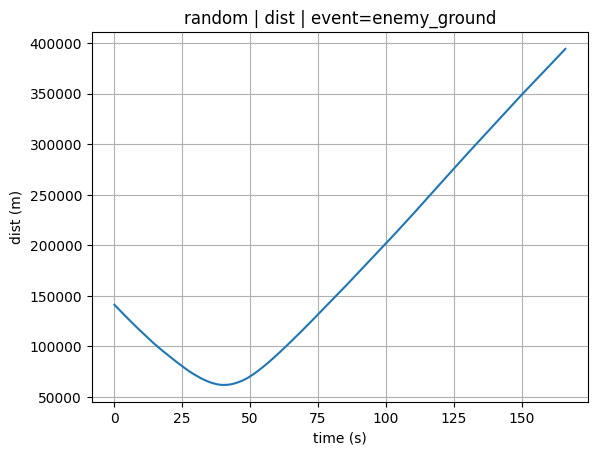

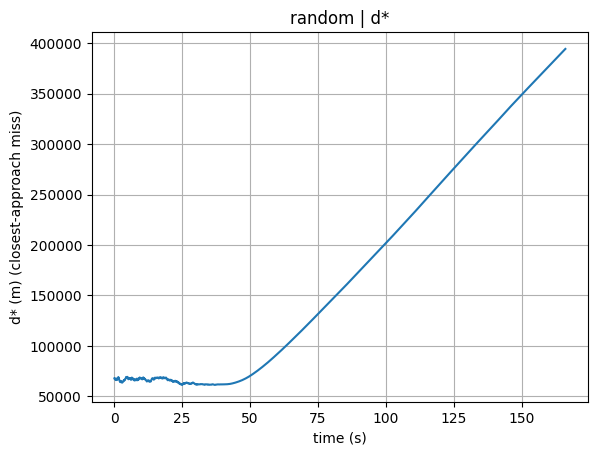

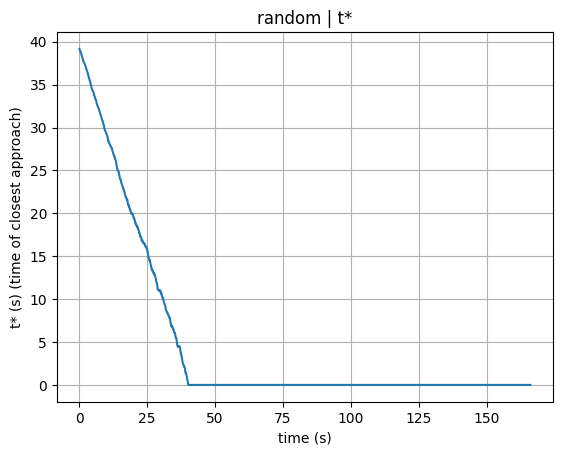

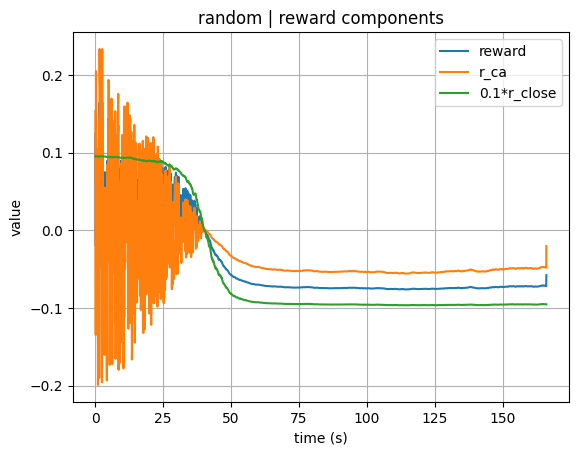

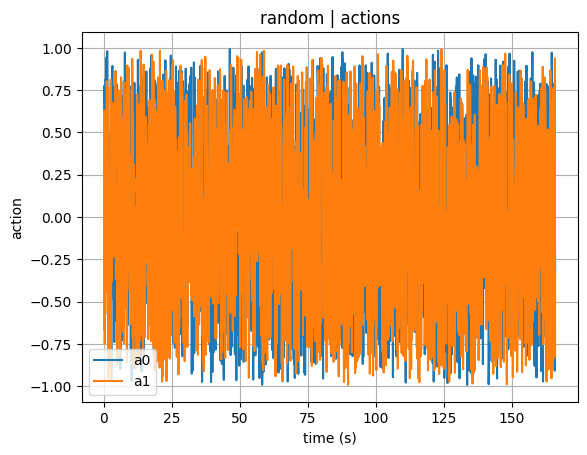

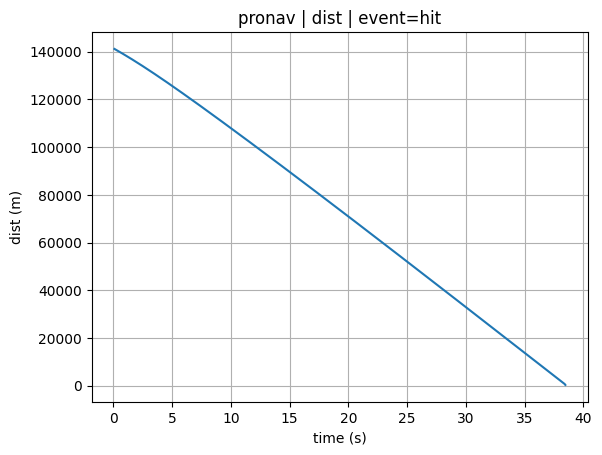

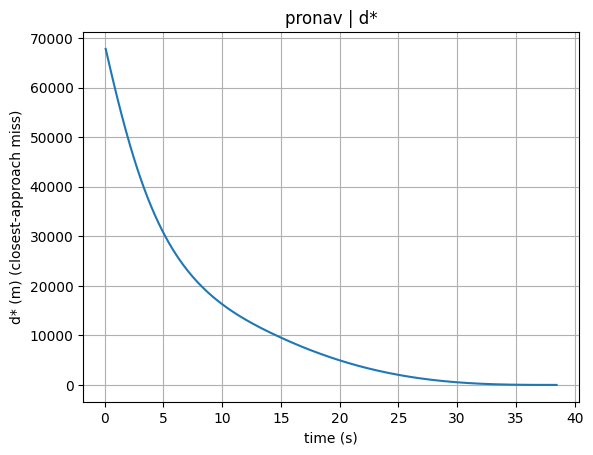

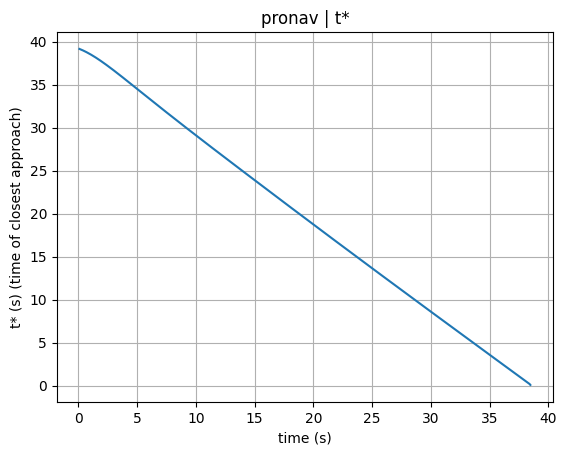

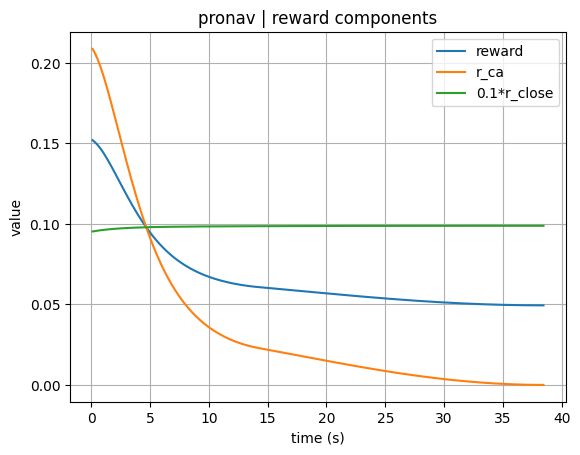

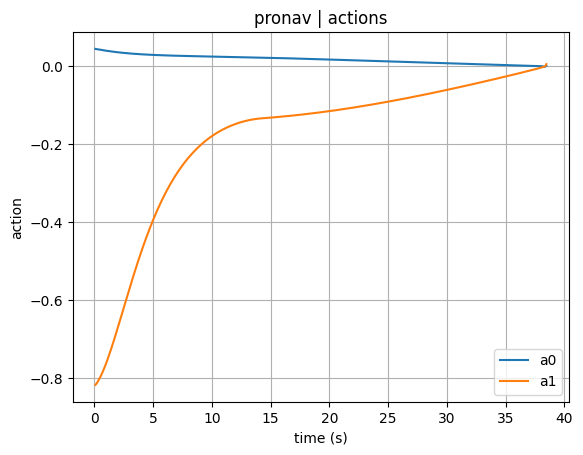

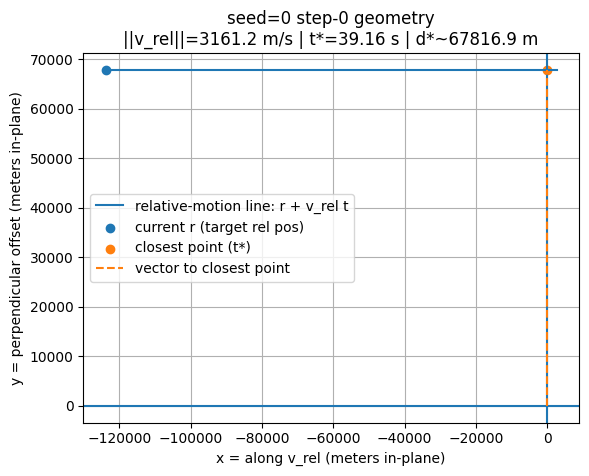

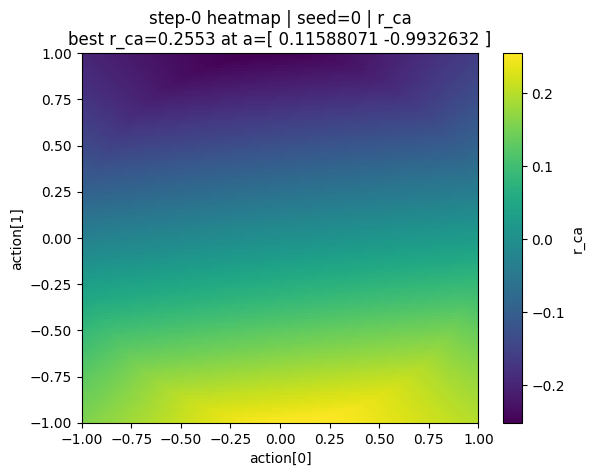

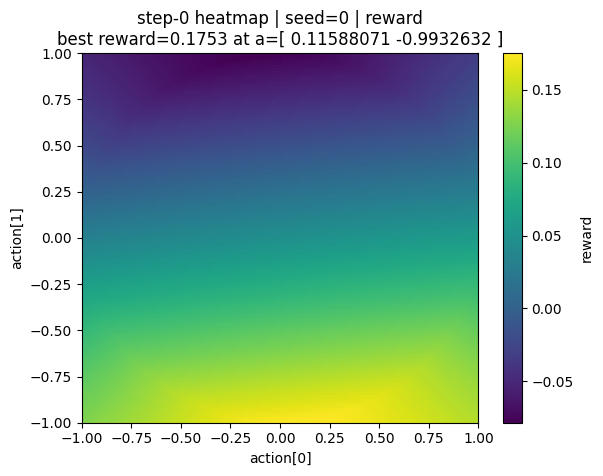

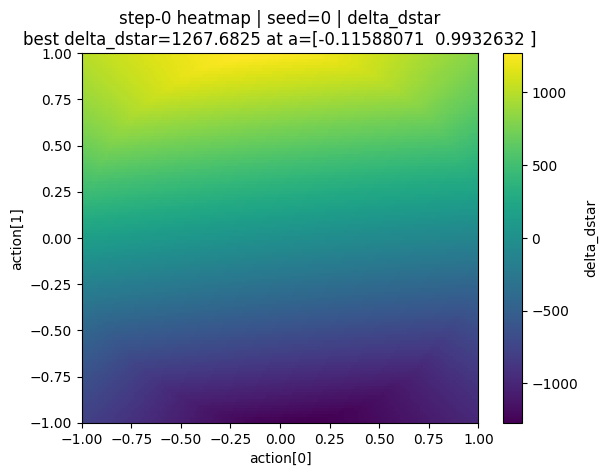

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# ----------------------------
# Helpers: state snapshot/restore
# ----------------------------
def snapshot_env(env):
    """Minimal snapshot sufficient to replay step() deterministically."""
    return {
        "enemy_pos": env.enemy_pos.copy(),
        "defense_pos": env.defense_pos.copy(),
        "enemy_vel": env.enemy_vel.copy(),
        "defense_vel": env.defense_vel.copy(),
        "t": float(env.t),
        "done": bool(getattr(env, "done", False)),
        "success": bool(getattr(env, "success", False)),
        "min_dist": float(getattr(env, "min_dist", np.inf)),
        "ep_min_dist": float(getattr(env, "ep_min_dist", np.inf)),
        "ep_max_action_mag": float(getattr(env, "ep_max_action_mag", 0.0)),
        "time_to_hit": getattr(env, "time_to_hit", None),
        "terminal_event": getattr(env, "terminal_event", "running"),
        # for completeness (not strictly needed)
        "defense_x": float(getattr(env, "defense_x", env.defense_pos[0])),
        "defense_y": float(getattr(env, "defense_y", env.defense_pos[1])),
        "defense_z": float(getattr(env, "defense_z", env.defense_pos[2])),
        "enemy_x": float(getattr(env, "enemy_x", env.enemy_pos[0])),
        "enemy_y": float(getattr(env, "enemy_y", env.enemy_pos[1])),
        "enemy_z": float(getattr(env, "enemy_z", env.enemy_pos[2])),
    }

def restore_env(env, st):
    env.enemy_pos = st["enemy_pos"].copy()
    env.defense_pos = st["defense_pos"].copy()
    env.enemy_vel = st["enemy_vel"].copy()
    env.defense_vel = st["defense_vel"].copy()
    env.t = float(st["t"])
    env.done = bool(st["done"])
    env.success = bool(st["success"])
    env.min_dist = float(st["min_dist"])
    env.ep_min_dist = float(st["ep_min_dist"])
    env.ep_max_action_mag = float(st["ep_max_action_mag"])
    env.time_to_hit = st["time_to_hit"]
    env.terminal_event = st["terminal_event"]
    env.defense_x, env.defense_y, env.defense_z = st["defense_x"], st["defense_y"], st["defense_z"]
    env.enemy_x, env.enemy_y, env.enemy_z = st["enemy_x"], st["enemy_y"], st["enemy_z"]

def unit_ball_action(a):
    """Match your env semantics: clip then normalize to unit norm if needed."""
    a = np.clip(np.array(a, dtype=np.float32), -1.0, 1.0)
    n = float(np.linalg.norm(a))
    if n > 1.0:
        a = a / n
    return a.astype(np.float32)

# ----------------------------
# 1) Rollout logger + plots
# ----------------------------
def rollout_log(env, policy, seed=0, max_steps=2000):
    """
    policy: "random" | "pronav" | callable(obs)->action
    returns a dict of time-series arrays
    """
    obs, _ = env.reset(seed=seed)
    out = {
        "t": [],
        "dist": [],
        "dstar": [],
        "tstar": [],
        "reward": [],
        "r_ca": [],
        "r_close": [],
        "a0": [],
        "a1": [],
        "event": None
    }

    done = False
    steps = 0
    while not done and steps < max_steps:
        steps += 1

        if policy == "random":
            a = env.action_space.sample()
        elif policy == "pronav":
            a = env.calculate_pronav()
        else:
            a = policy(obs)

        a = unit_ball_action(a)

        # log BEFORE step (geometry)
        phi, d_star, t_star = env._phi_closest_approach()
        dist = float(np.linalg.norm(env.enemy_pos - env.defense_pos))

        obs, rew, terminated, truncated, info = env.step(a)
        done = bool(terminated or truncated)

        out["t"].append(float(env.t))
        out["dist"].append(dist)
        out["dstar"].append(float(d_star))
        out["tstar"].append(float(t_star))
        out["reward"].append(float(rew))
        out["r_ca"].append(float(info.get("r_ca", np.nan)))
        out["r_close"].append(float(info.get("r_close", np.nan)))
        out["a0"].append(float(a[0]))
        out["a1"].append(float(a[1]))

        if done:
            out["event"] = info.get("event", "unknown")

    # arrays
    for k in ["t","dist","dstar","tstar","reward","r_ca","r_close","a0","a1"]:
        out[k] = np.asarray(out[k], dtype=float)
    return out

def plot_rollout(log, title="rollout"):
    # distance
    plt.figure()
    plt.plot(log["t"], log["dist"])
    plt.xlabel("time (s)")
    plt.ylabel("dist (m)")
    plt.title(f"{title} | dist | event={log['event']}")
    plt.grid(True)

    # d*
    plt.figure()
    plt.plot(log["t"], log["dstar"])
    plt.xlabel("time (s)")
    plt.ylabel("d* (m) (closest-approach miss)")
    plt.title(f"{title} | d*")
    plt.grid(True)

    # t*
    plt.figure()
    plt.plot(log["t"], log["tstar"])
    plt.xlabel("time (s)")
    plt.ylabel("t* (s) (time of closest approach)")
    plt.title(f"{title} | t*")
    plt.grid(True)

    # reward components
    plt.figure()
    plt.plot(log["t"], log["reward"], label="reward")
    plt.plot(log["t"], log["r_ca"], label="r_ca")
    plt.plot(log["t"], 0.1 * log["r_close"], label="0.1*r_close")
    plt.xlabel("time (s)")
    plt.ylabel("value")
    plt.title(f"{title} | reward components")
    plt.grid(True)
    plt.legend()

    # actions
    plt.figure()
    plt.plot(log["t"], log["a0"], label="a0")
    plt.plot(log["t"], log["a1"], label="a1")
    plt.xlabel("time (s)")
    plt.ylabel("action")
    plt.title(f"{title} | actions")
    plt.grid(True)
    plt.legend()

# ----------------------------
# 2) Geometry snapshot plot (the “ray into infinity” picture)
# ----------------------------
def plot_closest_approach_geometry(env, title="closest approach geometry", t_line=40.0):
    """
    Draws a 2D picture in the plane spanned by v_rel and (component of r orthogonal to v_rel).
    In this plane:
      - the relative-motion line is a straight line
      - d* is literally the perpendicular offset from the origin to that line
      - t* is the time coordinate of the closest point
    """
    r = (env.enemy_pos - env.defense_pos).astype(np.float64)
    vrel = (env.enemy_vel - env.defense_vel).astype(np.float64)

    vnorm = float(np.linalg.norm(vrel)) + 1e-12
    e1 = vrel / vnorm  # along v_rel
    r_par = float(np.dot(r, e1))
    r_perp_vec = r - r_par * e1
    r_perp = float(np.linalg.norm(r_perp_vec))

    # closest approach time (same as your code, but in analytic 2D form)
    # t* = max(0, - r·v / ||v||^2) => since e1 = v/||v||, r·v = r_par*||v||
    t_star = max(0.0, -r_par / vnorm)

    # 2D coordinates: x along vrel, y perpendicular magnitude
    # starting point r is (r_par, r_perp_sign)
    # choose sign so y has direction of r_perp_vec relative to some e2
    if r_perp > 1e-12:
        e2 = r_perp_vec / r_perp
        y0 = float(np.dot(r, e2))  # should be +r_perp
    else:
        # degenerate (already on the line)
        e2 = np.zeros(3)
        y0 = 0.0

    x0 = r_par

    # line param: r(t) = r + vrel*t  -> x(t)=x0+||v|| t, y(t)=y0 (constant)
    ts = np.linspace(0.0, t_line, 200)
    xs = x0 + vnorm * ts
    ys = np.full_like(xs, y0)

    # closest point on the line at t*
    x_star = x0 + vnorm * t_star
    y_star = y0

    # origin is interceptor
    plt.figure()
    plt.axhline(0.0)
    plt.axvline(0.0)
    plt.plot(xs, ys, label="relative-motion line: r + v_rel t")
    plt.scatter([x0], [y0], label="current r (target rel pos)")
    plt.scatter([x_star], [y_star], label="closest point (t*)")

    # draw d* as a segment from origin to perpendicular foot:
    # in this 2D representation, the closest point to origin occurs at t*, but
    # the perpendicular from origin to the infinite line would be at x=0 when unconstrained.
    # Here (because we enforce t>=0), t* might be 0. This picture still shows the actual chosen closest point.
    plt.plot([0.0, x_star], [0.0, y_star], linestyle="--", label="vector to closest point")

    plt.xlabel("x = along v_rel (meters in-plane)")
    plt.ylabel("y = perpendicular offset (meters in-plane)")
    plt.title(f"{title}\n||v_rel||={vnorm:.1f} m/s | t*={t_star:.2f} s | d*~{abs(y_star):.1f} m")
    plt.grid(True)
    plt.legend()

# ----------------------------
# 3) Step-0 action heatmap: see “good vs bad actions”
# ----------------------------
def step0_action_heatmap(env_class, seed=0, grid=101, which="r_ca"):
    """
    which: "r_ca" | "reward" | "dstar_after" | "delta_dstar"
    """
    env = env_class()
    env.reset(seed=seed)

    # baseline d*
    _, d_before, _ = env._phi_closest_approach()

    st0 = snapshot_env(env)

    xs = np.linspace(-1.0, 1.0, grid)
    ys = np.linspace(-1.0, 1.0, grid)
    Z = np.full((grid, grid), np.nan, dtype=float)

    best = {"val": -np.inf, "a": None}

    for i, a0 in enumerate(xs):
        for j, a1 in enumerate(ys):
            a = unit_ball_action([a0, a1])

            restore_env(env, st0)
            obs = env._get_obs()  # not strictly needed
            obs, reward, terminated, truncated, info = env.step(a)

            # post-step d*
            _, d_after, _ = env._phi_closest_approach()
            delta = float(d_after - d_before)

            if which == "r_ca":
                val = float(info.get("r_ca", np.nan))
            elif which == "reward":
                val = float(reward)
            elif which == "dstar_after":
                val = float(d_after)
            elif which == "delta_dstar":
                val = float(delta)
            else:
                raise ValueError("bad which")

            Z[j, i] = val  # note transpose convention for imshow

            if np.isfinite(val) and val > best["val"]:
                best = {"val": val, "a": a.copy()}

    plt.figure()
    plt.imshow(
        Z,
        origin="lower",
        extent=[xs.min(), xs.max(), ys.min(), ys.max()],
        aspect="auto",
    )
    plt.colorbar(label=which)
    plt.xlabel("action[0]")
    plt.ylabel("action[1]")
    plt.title(f"step-0 heatmap | seed={seed} | {which}\nbest {which}={best['val']:.4f} at a={best['a']}")
    plt.grid(False)

    return best


# ----------------------------
# 4) r_ca vs future miss: "can PPO rank actions?" (use with scan_initial_state_k_steps result)
# ----------------------------
def scatter_rca_vs_future_miss(scan_result):
    """scan_result = return value of scan_initial_state_k_steps(); keys: r_ca_first, min_dist, ..."""
    x = scan_result["r_ca_first"]
    y = scan_result["min_dist"]
    plt.figure()
    plt.scatter(x, y, s=8)
    plt.xlabel("r_ca at step 0")
    plt.ylabel("min_dist after K-step rollout")
    plt.title("Does r_ca rank actions by future outcome?")
    plt.tight_layout()


# To use: run the K-step scan cell first, then:
# k_result = scan_initial_state_k_steps(env, n_actions=2048, K=20, sigma=1.0, seed=0)
# scatter_rca_vs_future_miss(k_result); plt.show()


env = missile_interception_3d()
log_r = rollout_log(env, "random", seed=0, max_steps=4000)
plot_rollout(log_r, "random")

env = missile_interception_3d()
log_pn = rollout_log(env, "pronav", seed=0, max_steps=4000)
plot_rollout(log_pn, "pronav")

env = missile_interception_3d()
env.reset(seed=0)
plot_closest_approach_geometry(env, title="seed=0 step-0 geometry", t_line=40.0)

best_rca = step0_action_heatmap(missile_interception_3d, seed=0, grid=121, which="r_ca")
best_reward = step0_action_heatmap(missile_interception_3d, seed=0, grid=121, which="reward")
best_dd = step0_action_heatmap(missile_interception_3d, seed=0, grid=121, which="delta_dstar")

plt.show()

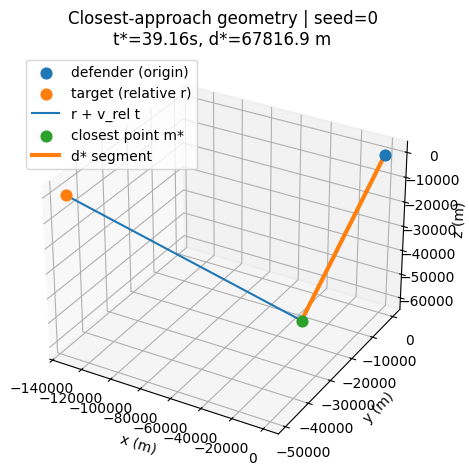

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_closest_approach_geometry(env, seed=0, t_line=40.0, n=200):
    obs, _ = env.reset(seed=seed)

    # Relative state (world frame)
    r = (env.enemy_pos - env.defense_pos).astype(np.float64)
    vrel = (env.enemy_vel - env.defense_vel).astype(np.float64)

    # Closest approach
    eps = 1e-9
    v2 = float(np.dot(vrel, vrel)) + eps
    t_star = max(0.0, -float(np.dot(r, vrel)) / v2)
    m_star = r + vrel * t_star
    d_star = float(np.linalg.norm(m_star))

    # Build line points
    ts = np.linspace(0.0, t_line, n)
    line = r[None, :] + ts[:, None] * vrel[None, :]

    # Plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Origin (defender)
    ax.scatter([0], [0], [0], s=60, label="defender (origin)")

    # Target relative position
    ax.scatter([r[0]], [r[1]], [r[2]], s=60, label="target (relative r)")

    # Relative-velocity line
    ax.plot(line[:,0], line[:,1], line[:,2], label="r + v_rel t")

    # Closest point and perpendicular segment
    ax.scatter([m_star[0]], [m_star[1]], [m_star[2]], s=60, label="closest point m*")
    ax.plot([0, m_star[0]], [0, m_star[1]], [0, m_star[2]], linewidth=3, label="d* segment")

    ax.set_title(f"Closest-approach geometry | seed={seed}\n"
                 f"t*={t_star:.2f}s, d*={d_star:.1f} m")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    ax.legend()
    plt.tight_layout()
    plt.show()

env = missile_interception_3d()
plot_closest_approach_geometry(env, seed=0)


=== K-STEP ACTION SCAN (1 step candidate + 19 steps ProNav) ===
seed=0 | n_actions=2048 | K=20 | sigma=1.0
Terminal events: {'running': 2048}
total_reward: p10=2.6879  p50=2.7715  p90=2.8604  max=2.8801
min_dist:     p10=135231.9  p50=135270.5  p90=135307.5  min=135223.1
dstar_final:  p10=48950.2  p50=49831.3  p90=50658.2  min=48754.6

Top actions by total reward (1+K steps):
  a=[ 0.1472676 -1.       ]  total_reward=+2.8801  min_dist=135223.3  d*=48754.6
  a=[ 0.12626205 -1.        ]  total_reward=+2.8801  min_dist=135223.2  d*=48754.6
  a=[ 0.12530889 -1.        ]  total_reward=+2.8801  min_dist=135223.2  d*=48754.6
  a=[ 0.15254073 -1.        ]  total_reward=+2.8801  min_dist=135223.3  d*=48754.7
  a=[ 0.12368735 -1.        ]  total_reward=+2.8801  min_dist=135223.2  d*=48754.7
  a=[ 0.15963332 -1.        ]  total_reward=+2.8801  min_dist=135223.3  d*=48754.8
  a=[ 0.16284482 -1.        ]  total_reward=+2.8801  min_dist=135223.3  d*=48754.8
  a=[ 0.10361419 -1.        ]  total_rewa

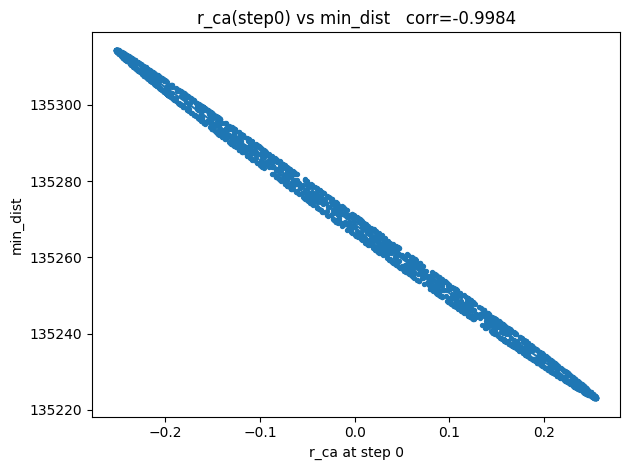

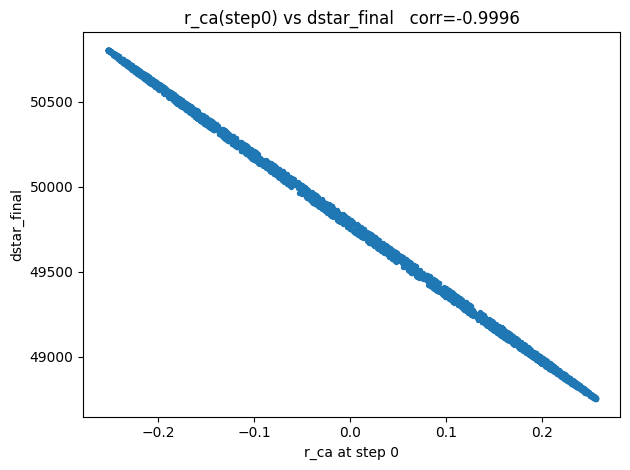

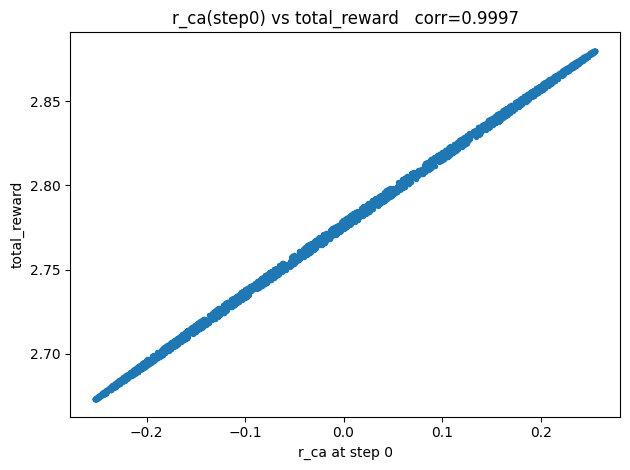

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_rca_vs_future(scan_result, y_key="min_dist", fit_line=True, title=None):
    """
    x-axis: r_ca at step 0
    y-axis: scan_result[y_key]  (e.g. "min_dist", "dstar_final", "total_reward")
    """
    if "r_ca_first" not in scan_result:
        raise KeyError(f"scan_result missing 'r_ca_first'. Keys: {list(scan_result.keys())}")
    if y_key not in scan_result:
        raise KeyError(f"scan_result missing '{y_key}'. Keys: {list(scan_result.keys())}")

    x = np.asarray(scan_result["r_ca_first"], dtype=float)
    y = np.asarray(scan_result[y_key], dtype=float)

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    corr = np.corrcoef(x, y)[0, 1] if x.size > 1 else np.nan

    plt.figure()
    plt.scatter(x, y, s=8)
    plt.xlabel("r_ca at step 0")
    plt.ylabel(y_key)
    if title is None:
        title = f"r_ca(step0) vs {y_key}   corr={corr:.4f}"
    plt.title(title)

    if fit_line and x.size > 2:
        a, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 200)
        plt.plot(xs, a * xs + b)

    plt.tight_layout()
    plt.show()


# ----------------------------
# IMPORTANT: CAPTURE THE RETURN
# ----------------------------
env = missile_interception_3d()

# This is the one that returns the dict with r_ca_first/min_dist/total_reward/etc.
scan_result = scan_initial_state_k_steps(
    env,
    n_actions=2048,
    K=20,
    sigma=1.0,
    seed=0
)

# 1) The plot you asked for: does r_ca rank actions by future miss?
scatter_rca_vs_future(scan_result, y_key="min_dist")

# 2) Also useful: does r_ca rank actions by final d*?
scatter_rca_vs_future(scan_result, y_key="dstar_final")

# 3) “More PPO-ish”: does r_ca rank actions by (your shaped) return?
scatter_rca_vs_future(scan_result, y_key="total_reward")

In [11]:
import numpy as np

# ----------------------------
# Continuation action generators
# ----------------------------
def _rand_action_box(rng):
    # deterministic "random" action, avoids env.action_space.sample() (which uses its own RNG)
    return rng.uniform(-1.0, 1.0, size=(2,)).astype(np.float32)

def _unit_ball_action(a):
    # match env.step() semantics (clip then normalize if norm>1)
    a = np.clip(np.array(a, dtype=np.float32), -1.0, 1.0)
    n = float(np.linalg.norm(a))
    if n > 1.0:
        a = a / n
    return a.astype(np.float32)

def continuation_action(env, obs, mode, a_candidate, rng, p_pronav=1.0):
    """
    mode:
      - "zero"         : [0,0]
      - "random"       : uniform random action
      - "repeat"       : repeat candidate action
      - "pronav"       : ProNav action
      - "mix"          : with prob p_pronav use ProNav else random
    """
    if mode == "zero":
        return np.zeros(2, dtype=np.float32)
    if mode == "random":
        return _unit_ball_action(_rand_action_box(rng))
    if mode == "repeat":
        return _unit_ball_action(a_candidate)
    if mode == "pronav":
        return _unit_ball_action(env.calculate_pronav())
    if mode == "mix":
        if rng.rand() < float(p_pronav):
            return _unit_ball_action(env.calculate_pronav())
        else:
            return _unit_ball_action(_rand_action_box(rng))
    raise ValueError(f"unknown mode: {mode}")


# ----------------------------
# One candidate rollout: 1 step candidate + continuation
# ----------------------------
def eval_candidate_then_continue(env, a0, K, mode, rng, p_pronav=1.0, until_done=False, max_steps=4000):
    """
    First step uses action a0 (candidate).
    Then we follow 'mode' policy.
    If until_done=True: ignore K and run to termination/truncation (bounded by max_steps).
    Else: run for at most K steps total (including first step).
    """
    total_reward = 0.0
    steps_taken = 0

    # STEP 0 (candidate)
    a0 = _unit_ball_action(a0)
    obs, r, term, trunc, info = env.step(a0)
    total_reward += float(r)
    steps_taken += 1

    r_ca_first = float(info.get("r_ca", np.nan))
    done = bool(term or trunc)
    last_event = str(info.get("event", "running"))

    # CONTINUATION
    step_cap = max_steps if until_done else int(K)
    while (not done) and (steps_taken < step_cap):
        a = continuation_action(env, obs, mode=mode, a_candidate=a0, rng=rng, p_pronav=p_pronav)
        obs, r, term, trunc, info = env.step(a)
        total_reward += float(r)
        steps_taken += 1
        done = bool(term or trunc)
        last_event = str(info.get("event", last_event))

    # outcomes at end of rollout
    min_dist = float(getattr(env, "ep_min_dist", np.inf))
    _, dstar_final, _ = env._phi_closest_approach()

    return {
        "total_reward": float(total_reward),
        "min_dist": float(min_dist),
        "dstar_final": float(dstar_final),
        "done": bool(done),
        "event": str(last_event),
        "steps_taken": int(steps_taken),
        "r_ca_first": float(r_ca_first),
    }


# ----------------------------
# Scan: same initial state, many candidate actions
# ----------------------------
def scan_initial_state_continuation(
    env,
    n_actions=2048,
    sigma=1.0,
    seed=0,
    K=20,
    mode="pronav",
    p_pronav=1.0,
    until_done=False,
    max_steps=4000,
    topk=10,
):
    """
    Returns scan_result dict:
      actions, r_ca_first, min_dist, dstar_final, total_reward, done, event
    """
    obs, _ = env.reset(seed=seed)
    S0 = get_env_state(env)

    # candidate actions ~ "initial PPO" sampling
    rng_actions = np.random.RandomState(seed + 12345)
    actions = sample_actions_like_initial_ppo(n_actions, sigma=sigma, rng=rng_actions)

    total_reward = np.zeros(n_actions, dtype=np.float64)
    min_dist = np.zeros(n_actions, dtype=np.float64)
    dstar_final = np.zeros(n_actions, dtype=np.float64)
    r_ca_first = np.zeros(n_actions, dtype=np.float64)
    done_arr = np.zeros(n_actions, dtype=bool)
    event_arr = np.empty(n_actions, dtype=object)

    event_counts = {}

    for i in range(n_actions):
        set_env_state(env, S0)

        # IMPORTANT: deterministic RNG per action index -> reduces noise for random/mix continuation
        rng_i = np.random.RandomState((seed + 1) * 10_000_000 + i)

        out = eval_candidate_then_continue(
            env,
            a0=actions[i],
            K=K,
            mode=mode,
            rng=rng_i,
            p_pronav=p_pronav,
            until_done=until_done,
            max_steps=max_steps,
        )

        total_reward[i] = out["total_reward"]
        min_dist[i] = out["min_dist"]
        dstar_final[i] = out["dstar_final"]
        r_ca_first[i] = out["r_ca_first"]
        done_arr[i] = out["done"]
        event_arr[i] = out["event"]

        e = out["event"]
        event_counts[e] = event_counts.get(e, 0) + 1

    # restore initial state
    set_env_state(env, S0)

    # summary prints
    def q(x, p): return float(np.percentile(x, p))
    valid = np.isfinite(r_ca_first)
    corr_min = np.corrcoef(r_ca_first[valid], min_dist[valid])[0,1] if np.sum(valid) > 1 else np.nan
    corr_d   = np.corrcoef(r_ca_first[valid], dstar_final[valid])[0,1] if np.sum(valid) > 1 else np.nan
    corr_ret = np.corrcoef(r_ca_first[valid], total_reward[valid])[0,1] if np.sum(valid) > 1 else np.nan

    horizon_tag = "FULL" if until_done else f"K={K}"
    mix_tag = f" (p_pronav={p_pronav:.2f})" if mode == "mix" else ""
    print(f"\n=== CONTINUATION SCAN | seed={seed} | n={n_actions} | {horizon_tag} | mode={mode}{mix_tag} ===")
    print("Terminal events:", event_counts)
    print("total_reward: p10={:.4f} p50={:.4f} p90={:.4f} max={:.4f}".format(q(total_reward,10), q(total_reward,50), q(total_reward,90), float(total_reward.max())))
    print("min_dist:     p10={:.1f} p50={:.1f} p90={:.1f} min={:.1f}".format(q(min_dist,10), q(min_dist,50), q(min_dist,90), float(min_dist.min())))
    print("dstar_final:  p10={:.1f} p50={:.1f} p90={:.1f} min={:.1f}".format(q(dstar_final,10), q(dstar_final,50), q(dstar_final,90), float(dstar_final.min())))
    print("corr(r_ca0, min_dist)   = {:.4f}  (want NEG)".format(corr_min))
    print("corr(r_ca0, dstar_final)= {:.4f}  (want NEG)".format(corr_d))
    print("corr(r_ca0, total_reward)= {:.4f} (want POS)".format(corr_ret))

    # top-k by outcomes
    idx_best_ret = np.argsort(-total_reward)[:topk]
    idx_best_md  = np.argsort(min_dist)[:topk]
    print("\nTop actions by total_reward:")
    for j in idx_best_ret:
        print(f"  a={actions[j]}  R={total_reward[j]:+.4f}  min_dist={min_dist[j]:.1f}  d*={dstar_final[j]:.1f}  r_ca0={r_ca_first[j]:+.4f}  event={event_arr[j]}")
    print("\nTop actions by min_dist:")
    for j in idx_best_md:
        print(f"  a={actions[j]}  min_dist={min_dist[j]:.1f}  R={total_reward[j]:+.4f}  d*={dstar_final[j]:.1f}  r_ca0={r_ca_first[j]:+.4f}  event={event_arr[j]}")

    return {
        "actions": actions,
        "total_reward": total_reward,
        "min_dist": min_dist,
        "dstar_final": dstar_final,
        "r_ca_first": r_ca_first,
        "done": done_arr,
        "event": event_arr,
        "mode": mode,
        "p_pronav": float(p_pronav),
        "until_done": bool(until_done),
        "K": int(K),
        "seed": int(seed),
    }

In [12]:
import matplotlib.pyplot as plt

env = missile_interception_3d()

K = 20
n_actions = 2048
seed = 0
sigma = 1.0

results = {}

# 1) zero-action continuation (K steps)
results["zero_K"] = scan_initial_state_continuation(
    env, n_actions=n_actions, sigma=sigma, seed=seed, K=K,
    mode="zero", until_done=False
)

# 2) random continuation (K steps)
results["random_K"] = scan_initial_state_continuation(
    env, n_actions=n_actions, sigma=sigma, seed=seed, K=K,
    mode="random", until_done=False
)

# 3) repeat-the-same-action continuation (K steps)
results["repeat_K"] = scan_initial_state_continuation(
    env, n_actions=n_actions, sigma=sigma, seed=seed, K=K,
    mode="repeat", until_done=False
)

# 4) mix 75% ProNav / 25% random (K steps)
results["mix75_K"] = scan_initial_state_continuation(
    env, n_actions=n_actions, sigma=sigma, seed=seed, K=K,
    mode="mix", p_pronav=0.75, until_done=False
)

# 5) mix 50% ProNav / 50% random (K steps)
results["mix50_K"] = scan_initial_state_continuation(
    env, n_actions=n_actions, sigma=sigma, seed=seed, K=K,
    mode="mix", p_pronav=0.50, until_done=False
)

# 6) ProNav to termination (FULL episode)
# This can be expensive with 2048 actions. If it’s slow, drop n_actions to 512.
results["pronav_FULL"] = scan_initial_state_continuation(
    env, n_actions=512, sigma=sigma, seed=seed, K=K,  # K ignored when until_done=True
    mode="pronav", until_done=True, max_steps=4000
)

# ---- plot the same 3 scatter diagnostics for each result ----
for name, scan_result in results.items():
    scatter_rca_vs_future(scan_result, use="min_dist")
    scatter_rca_vs_future(scan_result, use="dstar_final")
    scatter_rca_vs_future(scan_result, use="total_reward")
    plt.suptitle(name)  # optional; may or may not show depending on your scatter fn


=== CONTINUATION SCAN | seed=0 | n=2048 | K=20 | mode=zero ===
Terminal events: {'running': 2048}
total_reward: p10=0.8545 p50=0.9567 p90=1.0678 max=1.0925
min_dist:     p10=135598.9 p50=135644.8 p90=135688.3 min=135588.3
dstar_final:  p10=66791.3 p50=67889.6 p90=68899.1 min=66547.0
corr(r_ca0, min_dist)   = -0.9984  (want NEG)
corr(r_ca0, dstar_final)= -1.0000  (want NEG)
corr(r_ca0, total_reward)= 1.0000 (want POS)

Top actions by total_reward:
  a=[ 0.10361419 -1.        ]  R=+1.0925  min_dist=135588.5  d*=66547.0  r_ca0=+0.2553  event=running
  a=[ 0.12368735 -1.        ]  R=+1.0925  min_dist=135588.5  d*=66547.1  r_ca0=+0.2552  event=running
  a=[ 0.12626205 -1.        ]  R=+1.0925  min_dist=135588.5  d*=66547.1  r_ca0=+0.2552  event=running
  a=[ 0.09458404 -1.        ]  R=+1.0925  min_dist=135588.5  d*=66547.1  r_ca0=+0.2552  event=running
  a=[ 0.12530889 -1.        ]  R=+1.0925  min_dist=135588.5  d*=66547.1  r_ca0=+0.2552  event=running
  a=[ 0.09269764 -1.        ]  R=+1.09

TypeError: scatter_rca_vs_future() got an unexpected keyword argument 'use'

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# -------------------------
# Policy + Value network
# -------------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.pi = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, act_dim),
        )
        self.v = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        # log std as a free parameter (state-independent)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def dist(self, obs):
        mu = self.pi(obs)
        std = torch.exp(self.log_std).clamp(1e-4, 10.0)
        return torch.distributions.Normal(mu, std)

    def act(self, obs):
        dist = self.dist(obs)
        a = dist.sample()
        logp = dist.log_prob(a).sum(-1)
        v = self.v(obs).squeeze(-1)
        return a, logp, v

    def eval_actions(self, obs, act):
        dist = self.dist(obs)
        logp = dist.log_prob(act).sum(-1)
        ent = dist.entropy().sum(-1)
        v = self.v(obs).squeeze(-1)
        return logp, ent, v


# -------------------------
# GAE / returns
# -------------------------
def compute_gae(rews, vals, dones, gamma=0.999, lam=0.95):
    """
    rews, vals, dones are 1D numpy arrays length T
    vals should be length T+1 (bootstrap value at end)
    """
    T = len(rews)
    adv = np.zeros(T, dtype=np.float32)
    gae = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rews[t] + gamma * vals[t+1] * nonterminal - vals[t]
        gae = delta + gamma * lam * nonterminal * gae
        adv[t] = gae
    ret = adv + vals[:-1]
    return adv, ret


# -------------------------
# IMPORTANT NOTE ABOUT YOUR ENV
# -------------------------
def env_action_from_policy_action(a_np):
    """
    If your env renormalizes to unit-ball internally, PPO's log-prob no longer matches executed action.
    For a microscope, keep it simple: clip to [-1,1] and pass through.
    (But ideally: remove unit-ball renorm in env during training experiments.)
    """
    a = np.clip(a_np, -1.0, 1.0).astype(np.float32)
    return a


# -------------------------
# Rollout collection (single env)
# -------------------------
@torch.no_grad()
def collect_rollout(env, ac, T=1024, device="cpu"):
    obs, _ = env.reset()
    obs_buf = []
    act_buf = []
    logp_buf = []
    rew_buf = []
    done_buf = []
    val_buf = []
    proj_buf = []
    mag_in_buf = []
    mag_exec_buf = []

    for _ in range(T):
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        a_t, logp_t, v_t = ac.act(obs_t)

        a_np = a_t.squeeze(0).cpu().numpy()
        a_env = env_action_from_policy_action(a_np)

        obs2, rew, terminated, truncated, info = env.step(a_env)
        done = float(terminated or truncated)

        obs_buf.append(obs)
        act_buf.append(a_np)        # store *pre-clip* action for logprob consistency
        logp_buf.append(logp_t.item())
        rew_buf.append(float(rew))
        done_buf.append(done)
        val_buf.append(v_t.item())
        proj_buf.append(info.get("proj_fired", 0.0))
        mag_in_buf.append(info.get("mag_in", np.nan))
        mag_exec_buf.append(info.get("mag_exec", np.nan))

        obs = obs2
        if done:
            obs, _ = env.reset()

    # bootstrap value
    obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    v_last = ac.v(obs_t).item()
    val_buf.append(v_last)

    data = {
        "obs": np.asarray(obs_buf, dtype=np.float32),
        "act": np.asarray(act_buf, dtype=np.float32),
        "logp": np.asarray(logp_buf, dtype=np.float32),
        "rew": np.asarray(rew_buf, dtype=np.float32),
        "done": np.asarray(done_buf, dtype=np.float32),
        "val": np.asarray(val_buf, dtype=np.float32),  # length T+1
        "proj": np.asarray(proj_buf, dtype=np.float32),
        "mag_in": np.asarray(mag_in_buf, dtype=np.float32),
        "mag_exec": np.asarray(mag_exec_buf, dtype=np.float32),
    }
    return data


# -------------------------
# PPO update
# -------------------------
def ppo_update(ac, opt, data, *,
               gamma=0.999, lam=0.95,
               clip_eps=0.2, vf_coef=0.5, ent_coef=0.0,
               epochs=10, mb=256, device="cpu"):

    adv, ret = compute_gae(data["rew"], data["val"], data["done"], gamma=gamma, lam=lam)
    adv = (adv - adv.mean()) / (adv.std() + 1e-8)

    obs = torch.tensor(data["obs"], dtype=torch.float32, device=device)
    act = torch.tensor(data["act"], dtype=torch.float32, device=device)
    logp_old = torch.tensor(data["logp"], dtype=torch.float32, device=device)
    adv_t = torch.tensor(adv, dtype=torch.float32, device=device)
    ret_t = torch.tensor(ret, dtype=torch.float32, device=device)

    N = obs.shape[0]
    idx = np.arange(N)

    # diagnostics accumulators
    last = {}

    for _ in range(epochs):
        np.random.shuffle(idx)
        for start in range(0, N, mb):
            j = idx[start:start+mb]

            logp, ent, v = ac.eval_actions(obs[j], act[j])
            ratio = torch.exp(logp - logp_old[j])

            # clipped policy loss
            surr1 = ratio * adv_t[j]
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_t[j]
            pi_loss = -(torch.min(surr1, surr2)).mean()

            # value loss
            v_loss = 0.5 * (ret_t[j] - v).pow(2).mean()

            # entropy bonus
            ent_loss = -ent.mean()

            loss = pi_loss + vf_coef * v_loss + ent_coef * ent_loss

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(ac.parameters(), 1.0)
            opt.step()

            with torch.no_grad():
                approx_kl = (logp_old[j] - logp).mean().item()
                clipfrac = (torch.abs(ratio - 1.0) > clip_eps).float().mean().item()
                last = {
                    "pi_loss": pi_loss.item(),
                    "v_loss": v_loss.item(),
                    "ent": ent.mean().item(),
                    "approx_kl": approx_kl,
                    "clipfrac": clipfrac,
                    "adv_std": float(adv_t.std().item()),
                }

    return last


# -------------------------
# Main training loop (tiny)
# -------------------------
def train_micro_ppo(env, total_updates=50, T=1024, lr=3e-4, device="cpu"):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    ac = ActorCritic(obs_dim, act_dim).to(device)
    opt = optim.Adam(ac.parameters(), lr=lr)

    for u in range(total_updates):
        data = collect_rollout(env, ac, T=T, device=device)
        stats = ppo_update(ac, opt, data, device=device)
        proj_rate = float(data["proj"].mean())
        mag_in_mean = float(np.nanmean(data["mag_in"]))
        mag_exec_mean = float(np.nanmean(data["mag_exec"]))
        print(
            f"upd {u:03d} | rew_mean={data['rew'].mean():+.4f} | rew_std={data['rew'].std():.4f} "
            f"| proj_rate={proj_rate:.3f} | mag_in={mag_in_mean:.3f} | mag_exec={mag_exec_mean:.3f} "
            f"| kl={stats['approx_kl']:+.2e} | clipfrac={stats['clipfrac']:.3f} | ent={stats['ent']:+.3f}"
        )

    return ac

# Debug run: few updates, longer rollouts for stable GAE
env_ppo = missile_interception_3d()
train_micro_ppo(env_ppo, total_updates=10, T=2048, lr=3e-4, device="cpu")


upd 000 | rew_mean=-0.0365 | rew_std=0.0517 | proj_rate=0.610 | mag_in=0.953 | mag_exec=0.851 | kl=+4.38e-03 | clipfrac=0.039 | ent=+2.840
upd 001 | rew_mean=-0.0252 | rew_std=0.0646 | proj_rate=0.618 | mag_in=0.962 | mag_exec=0.854 | kl=+1.05e-02 | clipfrac=0.070 | ent=+2.851
upd 002 | rew_mean=-0.0305 | rew_std=0.0598 | proj_rate=0.639 | mag_in=0.977 | mag_exec=0.866 | kl=+8.97e-03 | clipfrac=0.023 | ent=+2.849
upd 003 | rew_mean=-0.0305 | rew_std=0.0605 | proj_rate=0.610 | mag_in=0.970 | mag_exec=0.861 | kl=+7.80e-03 | clipfrac=0.055 | ent=+2.852
upd 004 | rew_mean=-0.0005 | rew_std=0.1043 | proj_rate=0.639 | mag_in=0.981 | mag_exec=0.864 | kl=+1.91e-02 | clipfrac=0.109 | ent=+2.856
upd 005 | rew_mean=+0.0113 | rew_std=0.0471 | proj_rate=0.639 | mag_in=0.982 | mag_exec=0.872 | kl=+1.16e-02 | clipfrac=0.027 | ent=+2.818
upd 006 | rew_mean=+0.0127 | rew_std=0.0544 | proj_rate=0.634 | mag_in=0.981 | mag_exec=0.866 | kl=+5.75e-03 | clipfrac=0.098 | ent=+2.796
upd 007 | rew_mean=-0.0009 

ActorCritic(
  (pi): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (v): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)